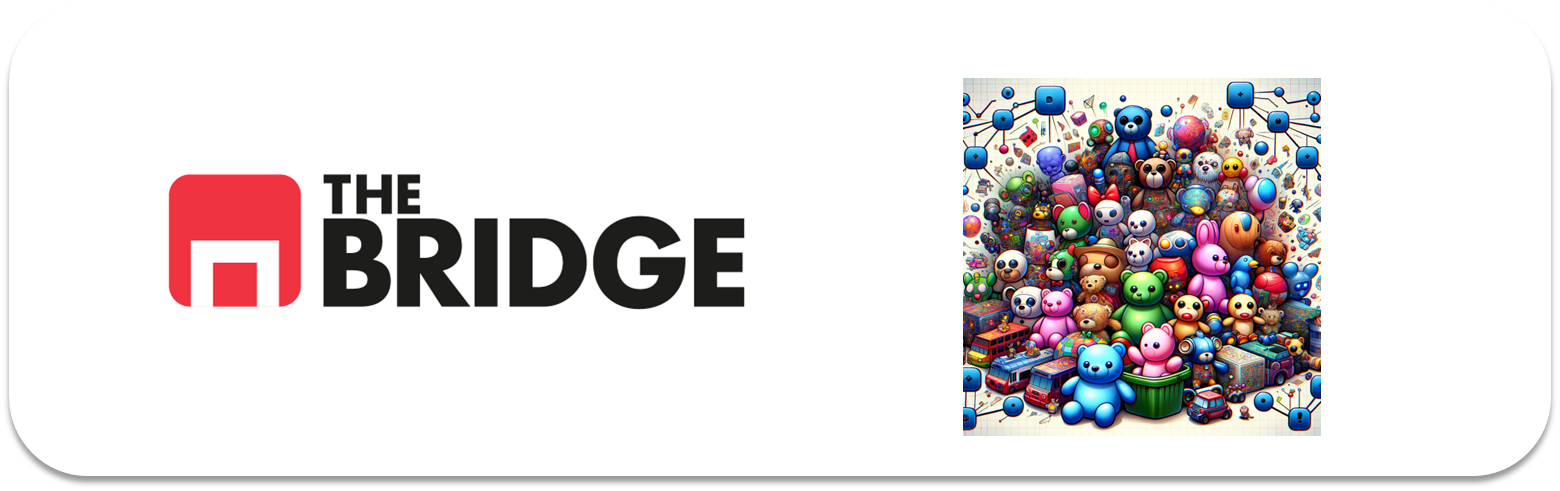

## PRACTICA OBLIGATORIA: **K-Means Clustering**

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado sobre imágenes para practicar con el algoritmo k-means. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [100]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
# Common imports
import numpy as np
import os
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.datasets import fetch_olivetti_faces

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix



import time


# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures

import matplotlib as mpl

mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings

## **#1**

Vamos a trabajar con un dataset también entre los "clásicos" (aunque a veces menos conocido) que es el de rostros Olivetti. Este dataset contiene 400 imágenes en escala de grises de 64 × 64 píxeles de rostros.   


Como en otros datasets de imágenes, estás están "aplanadas" de forma que cada pixel es una feature y por cada imagen hay $64\times 64 = 4096$ features.  

Se fotografiaron 40 personas diferentes (10 veces cada una) y esas fotografías se recogen en el dataset.  

La tarea habitual es entrenar un modelo que pueda predecir qué persona está representada en cada imagen, pero nosotros lo vamos a hacer de forma no supervisada. 



### #1.1


Carga el conjunto de datos usando la función `sklearn.datasets.fetch_olivetti_faces()`. Recuerda que se carga un "diccionario". Muestra su descripción acudiendo a la clave "DESCR".

In [ ]:
# Cargar datasetb
olivetti = fetch_olivetti_faces(shuffle=True, random_state=42)

In [7]:
print(f"\nClaves del diccionario: {olivetti.keys()}")


Claves del diccionario: dict_keys(['data', 'images', 'target', 'DESCR'])


In [8]:
# Mostrar descripción
print(olivetti['DESCR'])

.. _olivetti_faces_dataset:

The Olivetti faces dataset
--------------------------

`This dataset contains a set of face images`_ taken between April 1992 and
April 1994 at AT&T Laboratories Cambridge. The
:func:`sklearn.datasets.fetch_olivetti_faces` function is the data
fetching / caching function that downloads the data
archive from AT&T.

.. _This dataset contains a set of face images: https://cam-orl.co.uk/facedatabase.html

As described on the original website:

    There are ten different images of each of 40 distinct subjects. For some
    subjects, the images were taken at different times, varying the lighting,
    facial expressions (open / closed eyes, smiling / not smiling) and facial
    details (glasses / no glasses). All the images were taken against a dark
    homogeneous background with the subjects in an upright, frontal position
    (with tolerance for some side movement).

**Data Set Characteristics:**

=================   =====================
Classes              

### #1.2 

Aunque no lo vas a usar hasta el final de la práctica, muestra el target. Luego cargalo todo en un mismo dataframe (tendrás que añadir el target) y obtén otro dataset con todas las imagenes reordenadas aleatoriamente (emplea por ejemplo el método `sample` del dataframe o el método que tú quieras)

In [10]:
# Extraer datos
X = olivetti['data']        # Imágenes aplanadas
y = olivetti['target']      # Target (identidades)

In [11]:
print("\n MOSTRAR TARGET:")
print(f"   Shape: {y.shape}")
print(f"   Tipo: {y.dtype}")
print(f"   Valores únicos: {len(np.unique(y))} personas")
print(f"\n   Primeros 20 valores del target:")
print(f"   {y[:20]}")

print(f"\n Distribución del target:")
unique, counts = np.unique(y, return_counts=True)
print(f"   Cada persona aparece: {counts[0]} veces")


 MOSTRAR TARGET:
   Shape: (400,)
   Tipo: int64
   Valores únicos: 40 personas

   Primeros 20 valores del target:
   [20 28  3 21  9  8 32  9 26 12  0 36  5  7 13  4 27 37 23 38]

 Distribución del target:
   Cada persona aparece: 10 veces


In [12]:
# Opción 1: Nombres de columnas como 'pixel_0', 'pixel_1', ...
column_names = [f'pixel_{i}' for i in range(X.shape[1])]

# Crear DataFrame
df = pd.DataFrame(X, columns=column_names)

# Añadir target
df['target'] = y

print(f" DataFrame creado")
print(f"\n Información del DataFrame:")
print(f"   Shape: {df.shape}")
print(f"   Columnas: {df.shape[1]} ({df.shape[1]-1} píxeles + 1 target)")
print(f"   Filas: {df.shape[0]} imágenes")

 DataFrame creado

 Información del DataFrame:
   Shape: (400, 4097)
   Columnas: 4097 (4096 píxeles + 1 target)
   Filas: 400 imágenes


In [14]:
# Mostrar primeras filas y columnas
print(f"\n Primeras 5 filas y primeras 5 columnas + target:")
print(df.iloc[:5, [0, 1, 2, 3, 4, -1]])  # Primeros 5 píxeles + target

print(f"\n Información general:")
print(df.info(verbose=False))


 Primeras 5 filas y primeras 5 columnas + target:
    pixel_0   pixel_1   pixel_2   pixel_3   pixel_4  target
0  0.198347  0.235537  0.351240  0.409091  0.421488      20
1  0.185950  0.128099  0.115702  0.132231  0.185950      28
2  0.508264  0.603306  0.619835  0.628099  0.657025       3
3  0.136364  0.140496  0.185950  0.280992  0.318182      21
4  0.652893  0.644628  0.652893  0.706612  0.714876       9

 Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Columns: 4097 entries, pixel_0 to target
dtypes: float32(4096), int64(1)
memory usage: 6.3 MB
None


In [15]:
# Mostrar orden original
print("\n ANTES de reordenar (primeras 20 filas):")
print(f"   Target: {df['target'].head(20).values}")
print(f"   → Notar que están agrupadas por persona (0,0,0...)")


 ANTES de reordenar (primeras 20 filas):
   Target: [20 28  3 21  9  8 32  9 26 12  0 36  5  7 13  4 27 37 23 38]
   → Notar que están agrupadas por persona (0,0,0...)


In [16]:
# Reordenar aleatoriamente con sample()
df_shuffled = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [17]:
# Mostrar nuevo orden
print(f"\n DESPUÉS de reordenar (primeras 20 filas):")
print(f"   Target: {df_shuffled['target'].head(20).values}")
print(f"   → Ahora están mezcladas aleatoriamente ")


 DESPUÉS de reordenar (primeras 20 filas):
   Target: [18  0  5 22 22 27 16 18 31 35 12  5 22  0 25  7 25 27 23 35]
   → Ahora están mezcladas aleatoriamente 


In [18]:
print(f"\n Dataset reordenado guardado en 'df_shuffled'")
print(f"   Shape: {df_shuffled.shape}")


 Dataset reordenado guardado en 'df_shuffled'
   Shape: (400, 4097)


In [20]:
# Verificar que son los mismos datos
print(f"\n Verificación:")
print(f"   ¿Mismo número de filas? {len(df) == len(df_shuffled)}")
print(f"   ¿Misma distribución de target? {all(df['target'].value_counts().sort_index() == df_shuffled['target'].value_counts().sort_index())}")


 Verificación:
   ¿Mismo número de filas? True
   ¿Misma distribución de target? True


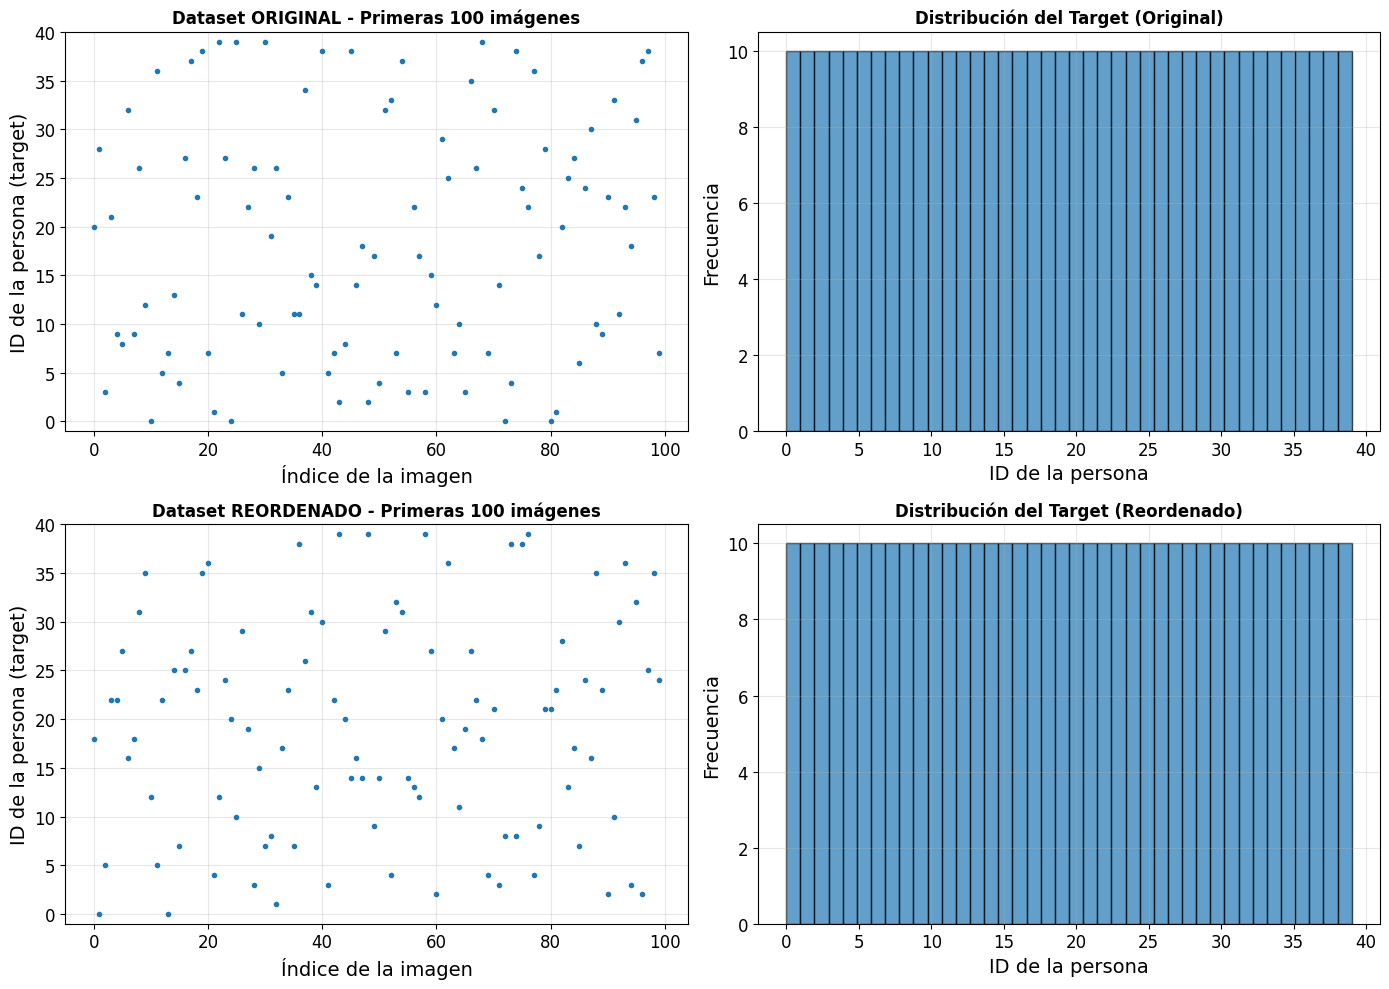

In [25]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Configuración
n_samples = 100

# ORIGINAL
axes[0, 0].plot(df['target'].head(n_samples), marker='o', markersize=3, linestyle='')
axes[0, 0].set_title('Dataset ORIGINAL - Primeras 100 imágenes', fontweight='bold')
axes[0, 0].set_xlabel('Índice de la imagen')
axes[0, 0].set_ylabel('ID de la persona (target)')
axes[0, 0].grid(alpha=0.3)
axes[0, 0].set_ylim(-1, 40)

axes[0, 1].hist(df['target'], bins=40, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Distribución del Target (Original)', fontweight='bold')
axes[0, 1].set_xlabel('ID de la persona')
axes[0, 1].set_ylabel('Frecuencia')
axes[0, 1].grid(alpha=0.3)

# REORDENADO
axes[1, 0].plot(df_shuffled['target'].head(n_samples), marker='o', markersize=3, linestyle='')
axes[1, 0].set_title('Dataset REORDENADO - Primeras 100 imágenes', fontweight='bold')
axes[1, 0].set_xlabel('Índice de la imagen')
axes[1, 0].set_ylabel('ID de la persona (target)')
axes[1, 0].grid(alpha=0.3)
axes[1, 0].set_ylim(-1, 40)

axes[1, 1].hist(df_shuffled['target'], bins=40, edgecolor='black', alpha=0.7)
axes[1, 1].set_title('Distribución del Target (Reordenado)', fontweight='bold')
axes[1, 1].set_xlabel('ID de la persona')
axes[1, 1].set_ylabel('Frecuencia')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()



### #1.3

Vamos a dividir en train y test, pero OJO RECUERDA QUE EN LOS PROBLEMAS NO SUPERVISADOS NO HAY SPLIT (porque no hay target), aquí lo hacemos para poder comparar posteriormente el clustering con la clasificación (ya que es uan práctica formativa).

Por tanto, divídelo en un conjunto de entrenamiento, un conjunto de validación y un conjunto de pruebas (80-10-10). Dado que el conjunto de datos es bastante pequeño, emplea un muestreo estratificado para asegurarse de que haya el mismo número de imágenes por persona en cada conjunto (estratificando por la columna que contenga el target)

NOTA: No hemos hecho hasta ahora la separación en tres sets, investiga por tu cuenta o bien haz primero un split 90-10 y luego otro split 89-11 sobre el de 80 (para que de los números aproximados), por ejemplo.

In [27]:
# PASO 1: Split 80% train - 20% resto (estratificado)
print(f"\n PASO 1: Split 80% train - 20% resto")

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y,
    test_size=0.2,      # 20% para temp (val + test)
    random_state=42,
    stratify=y          #  Estratificar por persona
)

print(f"   Train: {X_train.shape[0]} imágenes ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"   Temp: {X_temp.shape[0]} imágenes ({X_temp.shape[0]/len(X)*100:.1f}%)")


 PASO 1: Split 80% train - 20% resto
   Train: 320 imágenes (80.0%)
   Temp: 80 imágenes (20.0%)


In [29]:
# PASO 2: Split 50% val - 50% test del conjunto temporal
print(f"\n PASO 2: Split temp en 50% val - 50% test")

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp,
    test_size=0.5,      # 50% del 20% = 10% del total
    random_state=42,
    stratify=y_temp     #  Estratificar por persona
)

print(f"   Val: {X_val.shape[0]} imágenes ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"   Test: {X_test.shape[0]} imágenes ({X_test.shape[0]/len(X)*100:.1f}%)")


 PASO 2: Split temp en 50% val - 50% test
   Val: 40 imágenes (10.0%)
   Test: 40 imágenes (10.0%)


In [30]:
# Verificar estratificación
print(f"\n VERIFICACIÓN DE ESTRATIFICACIÓN:")

print(f"\n   TRAIN (primeras 5 personas):")
for person in range(5):
    count = np.sum(y_train == person)
    print(f"      Persona {person}: {count} imágenes")

print(f"\n   VAL (primeras 5 personas):")
for person in range(5):
    count = np.sum(y_val == person)
    print(f"      Persona {person}: {count} imágenes")

print(f"\n   TEST (primeras 5 personas):")
for person in range(5):
    count = np.sum(y_test == person)
    print(f"      Persona {person}: {count} imágenes")


 VERIFICACIÓN DE ESTRATIFICACIÓN:

   TRAIN (primeras 5 personas):
      Persona 0: 8 imágenes
      Persona 1: 8 imágenes
      Persona 2: 8 imágenes
      Persona 3: 8 imágenes
      Persona 4: 8 imágenes

   VAL (primeras 5 personas):
      Persona 0: 1 imágenes
      Persona 1: 1 imágenes
      Persona 2: 1 imágenes
      Persona 3: 1 imágenes
      Persona 4: 1 imágenes

   TEST (primeras 5 personas):
      Persona 0: 1 imágenes
      Persona 1: 1 imágenes
      Persona 2: 1 imágenes
      Persona 3: 1 imágenes
      Persona 4: 1 imágenes


### #1.4

Crea los pares X,y para train, validation y test.

In [31]:

# Función proporcionada
def plot_faces(faces, labels, n_cols=5):
    """
    Visualiza rostros en una cuadrícula
    
    Parámetros:
    - faces: array de imágenes aplanadas (n_samples, 4096)
    - labels: array de etiquetas (n_samples,)
    - n_cols: número de columnas en la cuadrícula
    """
    faces = faces.reshape(-1, 64, 64)  # Reshape a imágenes 64×64
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

Utiliza la siguiente función para visualizar alguna de las caras (observa que tienes que dar la X y la y, usa iloc en ambos datasets)

In [ ]:
def plot_faces(faces, labels, n_cols=5):
    faces = faces.reshape(-1, 64, 64)
    n_rows = (len(faces) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols, n_rows * 1.1))
    for index, (face, label) in enumerate(zip(faces, labels)):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(face, cmap="gray")
        plt.axis("off")
        plt.title(label)
    plt.show()

In [36]:
# Crear DataFrame de ejemplo para train
df_train = pd.DataFrame(X_train)
df_train['target'] = y_train

print(f"\n DataFrame de TRAIN:")
print(f"   Shape: {df_train.shape}")
print(f"   Columnas: {df_train.shape[1]} ({df_train.shape[1]-1} píxeles + 1 target)")


 DataFrame de TRAIN:
   Shape: (320, 4097)
   Columnas: 4097 (4096 píxeles + 1 target)


In [38]:
# Seleccionar primeras 10 filas con iloc
n_rows = 10

In [39]:
# Extraer features (todas las columnas excepto la última)
faces_iloc = df_train.iloc[:n_rows, :-1].values  # :-1 excluye 'target'

In [40]:
# Extraer target (última columna)
labels_iloc = df_train.iloc[:n_rows, -1].values  # -1 es 'target'


 Primeras 10 imágenes usando iloc:


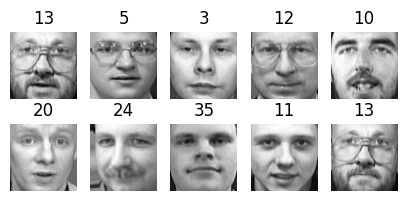

In [42]:
# Visualizar
print(f"\n Primeras {n_rows} imágenes usando iloc:")
plot_faces(faces_iloc, labels_iloc, n_cols=5)

### #1.5

Para acelerar las cosas, reduciremos la dimensionalidad de los datos utilizando PCA (técnica que veremos en el siguiente sprint). Modifica la siguiente celda de forma que las X se correspondan con las que has utilizado en el ejercicio anterior.

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(0.99)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)
X_test_pca = pca.transform(X_test)

pca.n_components_

In [45]:
# Aplicar PCA


pca = PCA(0.99)  # Mantener 99% de varianza

In [46]:
# Fit en TRAIN y transform en TRAIN
X_train_pca = pca.fit_transform(X_train)

In [47]:
# Solo transform en VAL y TEST (usa los componentes de TRAIN)
X_val_pca = pca.transform(X_val)  #  Corregido: X_val en lugar de X_valid
X_test_pca = pca.transform(X_test)


In [48]:
# Número de componentes seleccionadas
n_components = pca.n_components_


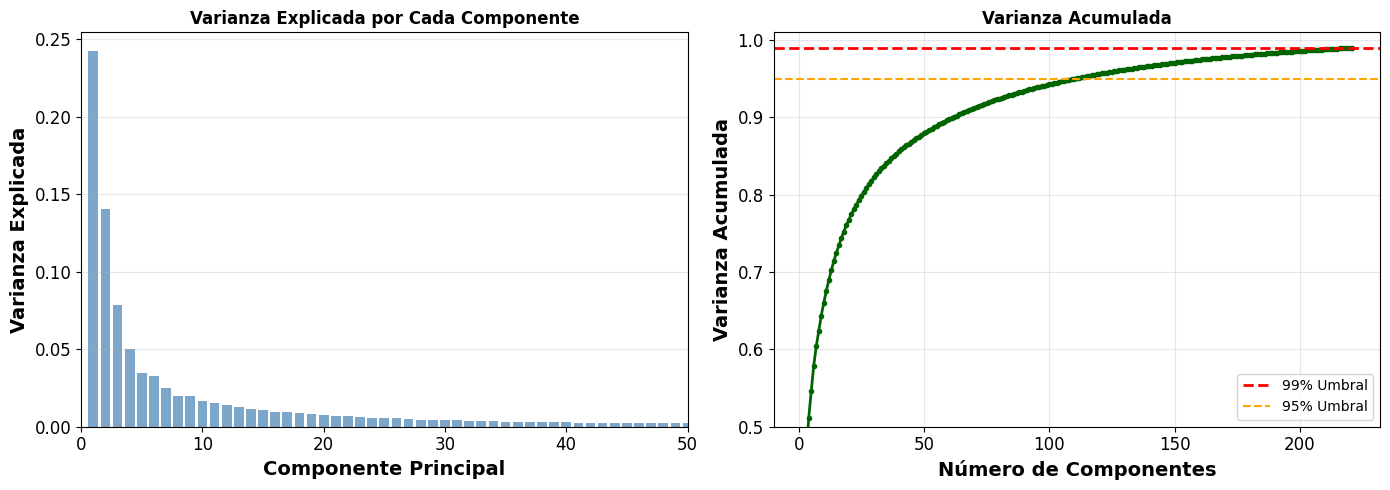

In [49]:
# Varianza explicada por cada componente
variance_ratio = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(variance_ratio)

# Visualización
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Varianza por componente
axes[0].bar(range(1, n_components+1), variance_ratio, alpha=0.7, color='steelblue')
axes[0].set_xlabel('Componente Principal', fontweight='bold')
axes[0].set_ylabel('Varianza Explicada', fontweight='bold')
axes[0].set_title('Varianza Explicada por Cada Componente', fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')
axes[0].set_xlim(0, min(50, n_components))  # Mostrar solo primeras 50

# Gráfico 2: Varianza acumulada
axes[1].plot(range(1, n_components+1), cumulative_variance, 
             marker='o', markersize=3, linewidth=2, color='darkgreen')
axes[1].axhline(y=0.99, color='red', linestyle='--', 
                linewidth=2, label='99% Umbral')
axes[1].axhline(y=0.95, color='orange', linestyle='--', 
                linewidth=1.5, label='95% Umbral')
axes[1].set_xlabel('Número de Componentes', fontweight='bold')
axes[1].set_ylabel('Varianza Acumulada', fontweight='bold')
axes[1].set_title('Varianza Acumulada', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].set_ylim(0.5, 1.01)

plt.tight_layout()
plt.show()

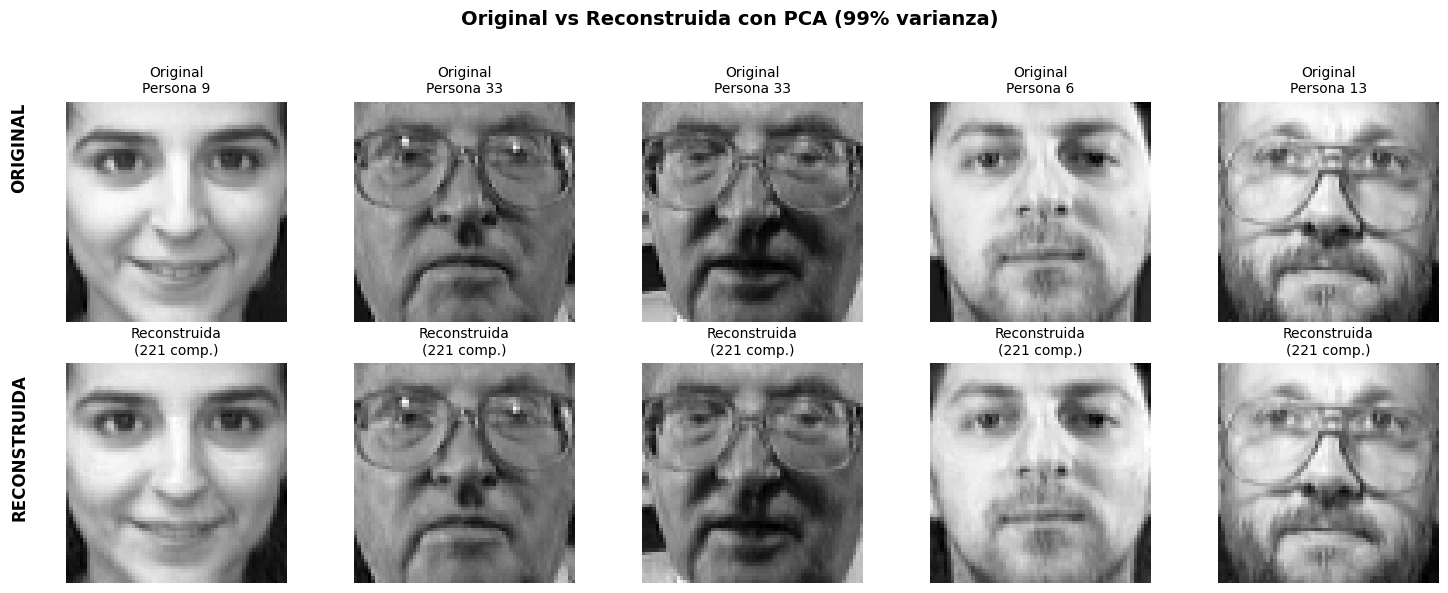

In [50]:
# Seleccionar 5 rostros aleatorios
np.random.seed(42)
n_samples = 5
indices = np.random.choice(len(X_train_pca), n_samples, replace=False)

# Originales
X_original = X_train[indices]

# Reconstruir desde PCA
X_reconstructed = pca.inverse_transform(X_train_pca[indices])

# Visualizar
fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))

for i in range(n_samples):
    # Original
    axes[0, i].imshow(X_original[i].reshape(64, 64), cmap='gray')
    axes[0, i].set_title(f'Original\nPersona {y_train[indices[i]]}', fontsize=10)
    axes[0, i].axis('off')
    
    # Reconstruida
    axes[1, i].imshow(X_reconstructed[i].reshape(64, 64), cmap='gray')
    axes[1, i].set_title(f'Reconstruida\n({n_components} comp.)', fontsize=10)
    axes[1, i].axis('off')

fig.text(0.02, 0.75, 'ORIGINAL', fontsize=12, fontweight='bold', 
         va='center', rotation=90)
fig.text(0.02, 0.25, 'RECONSTRUIDA', fontsize=12, fontweight='bold', 
         va='center', rotation=90)

plt.suptitle('Original vs Reconstruida con PCA (99% varianza)', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0.03, 0, 1, 0.96])
plt.show()


### 1.6

Aquí viene la parte del león. A continuación, agrupa las imágenes utilizando K-Means sobre el dataset de train reducido en el ejercicio anterior. Emplea el método del máximo de score de silueta para obtener el mejor k, probando con K de 5 en 5 hasta 150. ¿Cuál es el k que proporciona el mejor score de silueta? NOTA: Emplea todas las features (no hace falta seleccionar, y ya están escaladas entre 0 y 1)

In [59]:



# Configuración
k_values = range(5, 155, 5)  # 5, 10, 15, ..., 150
n_k_values = len(k_values)

print(f"\n CONFIGURACIÓN:")
print(f"   Valores de K a probar: {list(k_values)}")
print(f"   Total de modelos: {n_k_values}")
print(f"   Dataset: X_train_pca ({X_train_pca.shape})")

# Almacenar resultados
silhouette_scores = []
inertias = []  # Para método del codo (bonus)

print(f"\n Entrenando {n_k_values} modelos K-Means...")
print("   (Esto puede tardar 2-5 minutos)\n")

start_time = time.time()

# Entrenar K-Means para cada valor de K
for i, k in enumerate(k_values, 1):
    # Entrenar K-Means
    kmeans = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=10,           # Número de inicializaciones
        max_iter=300         # Máximo de iteraciones
    )
    
    # Predecir clusters
    labels = kmeans.fit_predict(X_train_pca)
    
    # Calcular Silhouette Score
    silhouette = silhouette_score(X_train_pca, labels)
    silhouette_scores.append(silhouette)
    
    # Guardar inercia (para método del codo)
    inertias.append(kmeans.inertia_)
    
    # Mostrar progreso cada 5 iteraciones
    if i % 5 == 0 or i == 1:
        print(f"   [{i:2d}/{n_k_values}] K={k:3d} → Silhouette={silhouette:.4f}")

elapsed_time = time.time() - start_time

print(f"\n Entrenamiento completado en {elapsed_time:.1f} segundos ({elapsed_time/60:.2f} min)")

print(f"""
 PARÁMETROS DE K-MEANS:

n_clusters: Número de clusters (K)
random_state: Semilla para reproducibilidad
n_init: Número de inicializaciones diferentes
  • K-Means es sensible a inicialización aleatoria
  • n_init=10 → Entrena 10 veces con diferentes inicios
  • Se queda con el mejor resultado

max_iter: Máximo de iteraciones
  • 300 es suficiente para convergencia
  • Suele converger en <100 iteraciones
""")


 CONFIGURACIÓN:
   Valores de K a probar: [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150]
   Total de modelos: 30
   Dataset: X_train_pca ((320, 221))

 Entrenando 30 modelos K-Means...
   (Esto puede tardar 2-5 minutos)

   [ 1/30] K=  5 → Silhouette=0.1069
   [ 5/30] K= 25 → Silhouette=0.1189
   [10/30] K= 50 → Silhouette=0.1710
   [15/30] K= 75 → Silhouette=0.1966
   [20/30] K=100 → Silhouette=0.2017
   [25/30] K=125 → Silhouette=0.2082
   [30/30] K=150 → Silhouette=0.1983

 Entrenamiento completado en 4.4 segundos (0.07 min)

 PARÁMETROS DE K-MEANS:

n_clusters: Número de clusters (K)
random_state: Semilla para reproducibilidad
n_init: Número de inicializaciones diferentes
  • K-Means es sensible a inicialización aleatoria
  • n_init=10 → Entrena 10 veces con diferentes inicios
  • Se queda con el mejor resultado

max_iter: Máximo de iteraciones
  • 300 es suficiente para convergencia
  • Suele conv

### #1.7

Repite el ejercio anterior empleando ahora el método del codo de Inercia. ¿Sale algo más concluyente o que refuerce el anterior resultado?


 MÉTODO 1: Búsqueda del Codo con Segunda Derivada
   K del codo (segunda derivada): 10
   Inercia en el codo: 14948.45


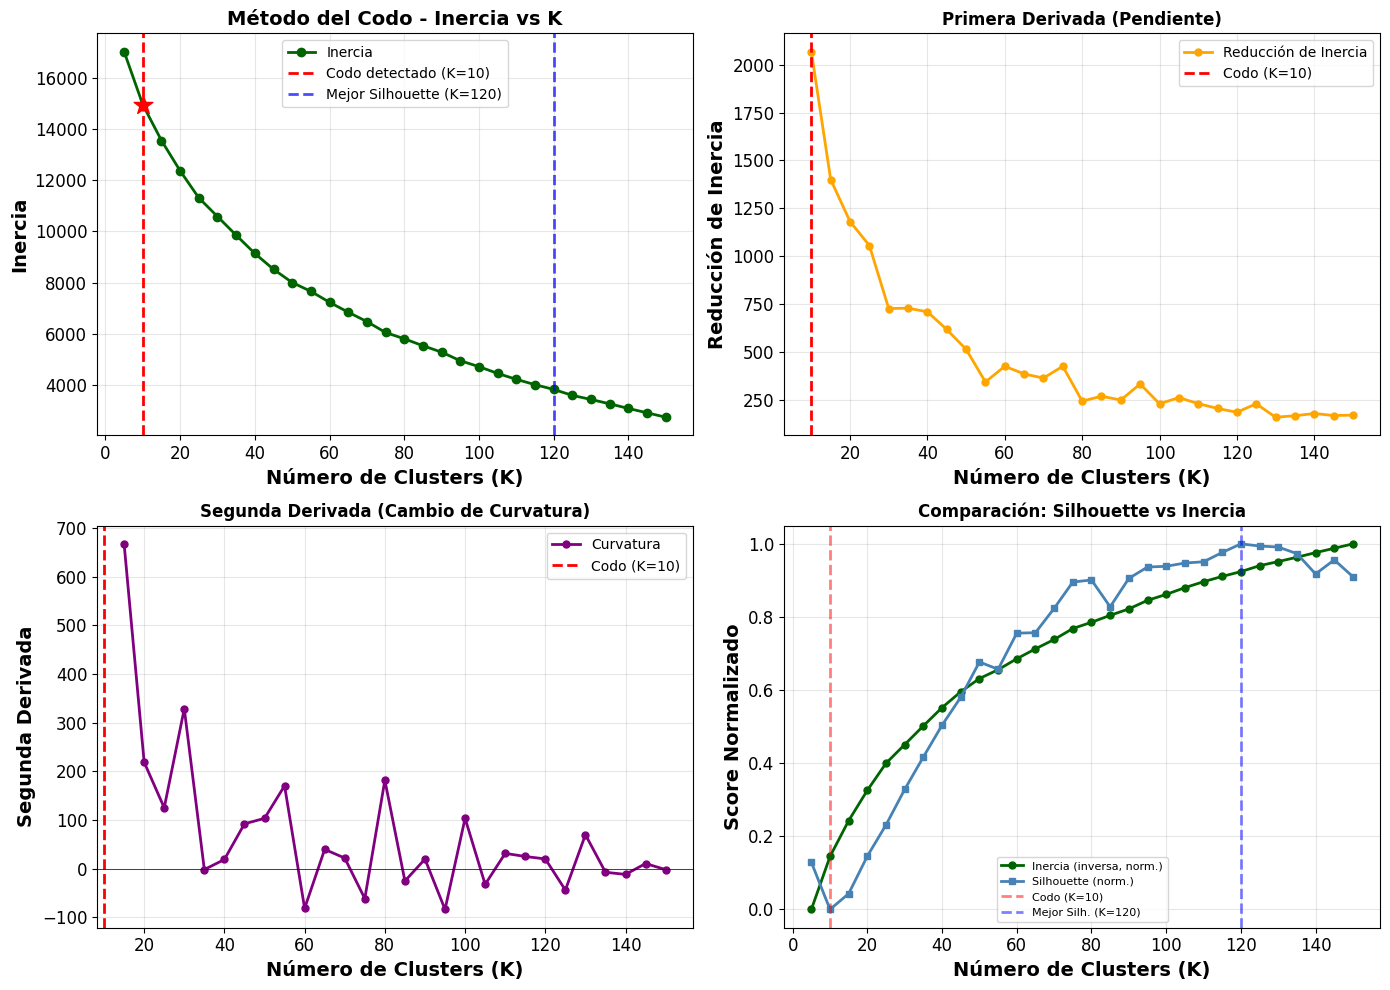


     COMPARACIÓN:
       Silhouette Score → K=120
       Método del Codo → K=10
       Diferencia: 110 clusters

    ¿COINCIDEN?
        NO - Diferencia significativa
    


In [73]:
import matplotlib.pyplot as plt
import numpy as np



# Verificar que tenemos las variables del paso anterior
if 'inertias' not in locals() or 'k_values' not in locals():
    print(" ERROR: Necesitas ejecutar el paso 1.6 primero")
    print("   Falta 'inertias' o 'k_values'")
else:
    # Convertir k_values a lista si es necesario
    k_values = list(k_values)
    
    # Encontrar mejor K por Silhouette (del paso anterior)
    if 'best_k' not in locals() or 'best_silhouette' not in locals():
        # Recalcular si no existe
        silhouette_scores = np.array(silhouette_scores)
        best_idx_silh = np.argmax(silhouette_scores)
        best_k = k_values[best_idx_silh]
        best_silhouette = silhouette_scores[best_idx_silh]
        print(f"\n Variables recuperadas del paso 1.6:")
        print(f"   best_k = {best_k}")
        print(f"   best_silhouette = {best_silhouette:.4f}")
    
    print(f"\n MÉTODO 1: Búsqueda del Codo con Segunda Derivada")
    
    # Calcular diferencias (primera derivada)
    diff_1 = np.diff(inertias)
    # Segunda derivada
    diff_2 = np.diff(diff_1)
    
    # El codo es donde la segunda derivada es máxima
    elbow_idx = np.argmax(diff_2) + 1
    elbow_k = k_values[elbow_idx]
    
    print(f"   K del codo (segunda derivada): {elbow_k}")
    print(f"   Inercia en el codo: {inertias[elbow_idx]:.2f}")
    
    # Visualización completa
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    # Gráfico 1: Inercia vs K (principal)
    axes[0, 0].plot(k_values, inertias, marker='o', linewidth=2, 
                   markersize=6, color='darkgreen', label='Inercia')
    axes[0, 0].axvline(x=elbow_k, color='red', linestyle='--', 
                      linewidth=2, label=f'Codo detectado (K={elbow_k})')
    axes[0, 0].axvline(x=best_k, color='blue', linestyle='--', 
                      linewidth=2, alpha=0.7, label=f'Mejor Silhouette (K={best_k})')
    axes[0, 0].scatter([elbow_k], [inertias[elbow_idx]], 
                      color='red', s=200, zorder=5, marker='*')
    axes[0, 0].set_xlabel('Número de Clusters (K)', fontweight='bold')
    axes[0, 0].set_ylabel('Inercia', fontweight='bold')
    axes[0, 0].set_title('Método del Codo - Inercia vs K', fontweight='bold', fontsize=14)
    axes[0, 0].legend()
    axes[0, 0].grid(alpha=0.3)
    
    # Gráfico 2: Primera derivada (pendiente)
    axes[0, 1].plot(k_values[1:], -diff_1, marker='o', linewidth=2, 
                   markersize=5, color='orange', label='Reducción de Inercia')
    axes[0, 1].axvline(x=elbow_k, color='red', linestyle='--', 
                      linewidth=2, label=f'Codo (K={elbow_k})')
    axes[0, 1].set_xlabel('Número de Clusters (K)', fontweight='bold')
    axes[0, 1].set_ylabel('Reducción de Inercia', fontweight='bold')
    axes[0, 1].set_title('Primera Derivada (Pendiente)', fontweight='bold')
    axes[0, 1].legend()
    axes[0, 1].grid(alpha=0.3)
    
    # Gráfico 3: Segunda derivada (curvatura)
    axes[1, 0].plot(k_values[2:], diff_2, marker='o', linewidth=2, 
                   markersize=5, color='purple', label='Curvatura')
    axes[1, 0].axvline(x=elbow_k, color='red', linestyle='--', 
                      linewidth=2, label=f'Codo (K={elbow_k})')
    axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1, 0].set_xlabel('Número de Clusters (K)', fontweight='bold')
    axes[1, 0].set_ylabel('Segunda Derivada', fontweight='bold')
    axes[1, 0].set_title('Segunda Derivada (Cambio de Curvatura)', fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(alpha=0.3)
    
    # Gráfico 4: Comparación Silhouette vs Inercia normalizada
    inertias_norm = (inertias - np.min(inertias)) / (np.max(inertias) - np.min(inertias))
    silhouette_norm = (silhouette_scores - np.min(silhouette_scores)) / (np.max(silhouette_scores) - np.min(silhouette_scores))
    
    axes[1, 1].plot(k_values, 1 - inertias_norm, marker='o', linewidth=2, 
                   markersize=5, color='darkgreen', label='Inercia (inversa, norm.)')
    axes[1, 1].plot(k_values, silhouette_norm, marker='s', linewidth=2, 
                   markersize=5, color='steelblue', label='Silhouette (norm.)')
    axes[1, 1].axvline(x=elbow_k, color='red', linestyle='--', 
                      linewidth=2, alpha=0.5, label=f'Codo (K={elbow_k})')
    axes[1, 1].axvline(x=best_k, color='blue', linestyle='--', 
                      linewidth=2, alpha=0.5, label=f'Mejor Silh. (K={best_k})')
    axes[1, 1].set_xlabel('Número de Clusters (K)', fontweight='bold')
    axes[1, 1].set_ylabel('Score Normalizado', fontweight='bold')
    axes[1, 1].set_title('Comparación: Silhouette vs Inercia', fontweight='bold')
    axes[1, 1].legend(fontsize=8)
    axes[1, 1].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"""
     COMPARACIÓN:
       Silhouette Score → K={best_k}
       Método del Codo → K={elbow_k}
       Diferencia: {abs(best_k - elbow_k)} clusters
       
    ¿COINCIDEN?
       {" SÍ - Diferencia mínima" if abs(best_k - elbow_k) <= 5 else " PARCIALMENTE - Diferencia moderada" if abs(best_k - elbow_k) <= 15 else " NO - Diferencia significativa"}
    """)

MÉTODO 2: Algoritmo Kneedle
   K del codo (Kneedle): 50


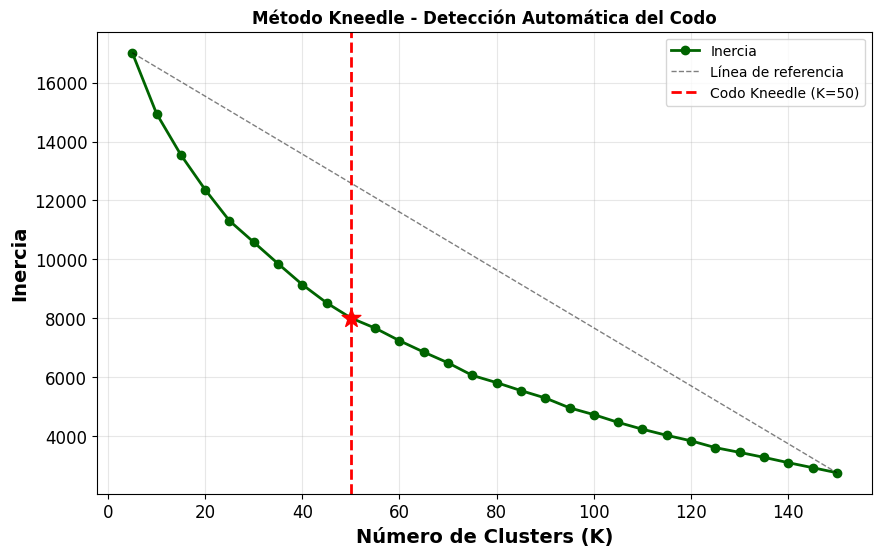

In [72]:

print("MÉTODO 2: Algoritmo Kneedle")


def find_elbow_kneedle(x, y):
    """Encuentra el codo usando método Kneedle"""
    x_norm = (x - np.min(x)) / (np.max(x) - np.min(x))
    y_norm = (y - np.min(y)) / (np.max(y) - np.min(y))
    
    x1, y1 = x_norm[0], y_norm[0]
    x2, y2 = x_norm[-1], y_norm[-1]
    
    distances = []
    for i in range(len(x_norm)):
        xi, yi = x_norm[i], y_norm[i]
        num = abs((y2 - y1) * xi - (x2 - x1) * yi + x2 * y1 - y2 * x1)
        den = np.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(num / den)
    
    return np.argmax(distances)

elbow_idx_kneedle = find_elbow_kneedle(np.array(k_values), np.array(inertias))
elbow_k_kneedle = k_values[elbow_idx_kneedle]

print(f"   K del codo (Kneedle): {elbow_k_kneedle}")

# Visualizar
plt.figure(figsize=(10, 6))
plt.plot(k_values, inertias, marker='o', linewidth=2, markersize=6, 
        color='darkgreen', label='Inercia')
plt.plot([k_values[0], k_values[-1]], [inertias[0], inertias[-1]], 
        'k--', linewidth=1, alpha=0.5, label='Línea de referencia')
plt.axvline(x=elbow_k_kneedle, color='red', linestyle='--', linewidth=2, 
           label=f'Codo Kneedle (K={elbow_k_kneedle})')
plt.scatter([elbow_k_kneedle], [inertias[elbow_idx_kneedle]], 
           color='red', s=200, zorder=5, marker='*')
plt.xlabel('Número de Clusters (K)', fontweight='bold')
plt.ylabel('Inercia', fontweight='bold')
plt.title('Método Kneedle - Detección Automática del Codo', fontweight='bold')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### #1.8

Quédate con el k obtenido con el método del score de silueta y asigna el modelo con ese k a una variable `best_model`

In [94]:


print(f"""
 DECISIÓN FINAL:

Usaremos K={best_k} según Silhouette Score porque:
   Mayor Silhouette Score ({best_silhouette:.4f})
   Métrica más confiable (considera separación Y cohesión)
   Menos subjetivo que el método del codo
""")

# Verificar si ya existe kmeans_final del paso 1.6
if 'kmeans_final' in locals():
    print(f"\n Modelo ya entrenado en paso 1.6")
    print(f"   Reutilizando kmeans_final con K={best_k}")
    
    # Asignar a best_model
    best_model = kmeans_final
    
else:
    print(f"\n Entrenando modelo final con K={best_k}...")
    
    from sklearn.cluster import KMeans
    
    # Entrenar K-Means con el mejor K
    best_model = KMeans(
        n_clusters=best_k,
        random_state=42,
        n_init=10,
        max_iter=300
    )
    
    # Fit sobre train
    best_model.fit(X_train_pca)
    
    print(f" Modelo entrenado correctamente")

# Información del modelo
print(f"\n INFORMACIÓN DEL MODELO GUARDADO:")
print(f"   Variable: best_model")
print(f"   Tipo: {type(best_model)}")
print(f"   K (n_clusters): {best_model.n_clusters}")
print(f"   Iteraciones hasta convergencia: {best_model.n_iter_}")
print(f"   Inercia: {best_model.inertia_:.2f}")

# Predecir clusters en train
y_train_clusters = best_model.predict(X_train_pca)

print(f"\n PREDICCIONES EN TRAIN:")
print(f"   Shape: {y_train_clusters.shape}")
print(f"   Clusters únicos: {len(np.unique(y_train_clusters))}")
print(f"   Rango: {y_train_clusters.min()} - {y_train_clusters.max()}")

# Distribución de clusters
unique_clusters, counts_clusters = np.unique(y_train_clusters, return_counts=True)

print(f"\n DISTRIBUCIÓN DE CLUSTERS:")
print(f"   Cluster más grande: {counts_clusters.max()} imágenes")
print(f"   Cluster más pequeño: {counts_clusters.min()} imágenes")
print(f"   Tamaño promedio: {counts_clusters.mean():.1f} ± {counts_clusters.std():.1f} imágenes")

print(f"\n Primeros 10 clusters:")
for i in range(min(10, len(unique_clusters))):
    cluster_id = unique_clusters[i]
    cluster_size = counts_clusters[i]
    print(f"   Cluster {cluster_id}: {cluster_size} imágenes")

# Calcular Silhouette Score final
from sklearn.metrics import silhouette_score

silhouette_train = silhouette_score(X_train_pca, y_train_clusters)

print(f"\n MÉTRICAS FINALES:")
print(f"   Silhouette Score (train): {silhouette_train:.4f}")
print(f"   Inercia: {best_model.inertia_:.2f}")

print(f"""
 MODELO GUARDADO CORRECTAMENTE

Variables disponibles:
  • best_model: Modelo K-Means con K={best_k} 
  • y_train_clusters: Clusters asignados a X_train_pca
  • best_k: {best_k}
  • best_silhouette: {best_silhouette:.4f}

Centroides del modelo:
  • best_model.cluster_centers_: Shape {best_model.cluster_centers_.shape}
  • Cada centroide es un "rostro promedio" del cluster
""")


 DECISIÓN FINAL:

Usaremos K=120 según Silhouette Score porque:
   Mayor Silhouette Score (0.2088)
   Métrica más confiable (considera separación Y cohesión)
   Menos subjetivo que el método del codo


 Entrenando modelo final con K=120...
 Modelo entrenado correctamente

 INFORMACIÓN DEL MODELO GUARDADO:
   Variable: best_model
   Tipo: <class 'sklearn.cluster._kmeans.KMeans'>
   K (n_clusters): 120
   Iteraciones hasta convergencia: 3
   Inercia: 3836.42

 PREDICCIONES EN TRAIN:
   Shape: (320,)
   Clusters únicos: 120
   Rango: 0 - 119

 DISTRIBUCIÓN DE CLUSTERS:
   Cluster más grande: 7 imágenes
   Cluster más pequeño: 1 imágenes
   Tamaño promedio: 2.7 ± 1.5 imágenes

 Primeros 10 clusters:
   Cluster 0: 3 imágenes
   Cluster 1: 4 imágenes
   Cluster 2: 6 imágenes
   Cluster 3: 5 imágenes
   Cluster 4: 2 imágenes
   Cluster 5: 3 imágenes
   Cluster 6: 4 imágenes
   Cluster 7: 7 imágenes
   Cluster 8: 4 imágenes
   Cluster 9: 4 imágenes

 MÉTRICAS FINALES:
   Silhouette Score (tra


 ¿QUÉ SON LOS CENTROIDES?

Los centroides son los "rostros promedio" de cada cluster:
  • Cada centroide es el punto central de un cluster
  • Representa las características promedio del grupo
  • En PCA están en {best_model.n_features_in_} dimensiones
  • Podemos reconstruirlos a 64×64 píxeles


 Reconstrucción de centroides:
   Centroides en PCA: (120, 221)
   Centroides en píxeles: (120, 4096)

 Mostrando 10 centroides (rostros promedio):


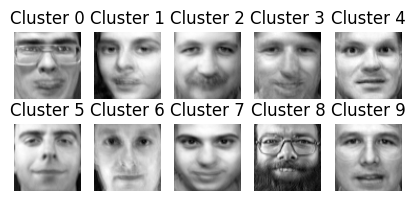

In [93]:

print("""
 ¿QUÉ SON LOS CENTROIDES?

Los centroides son los "rostros promedio" de cada cluster:
  • Cada centroide es el punto central de un cluster
  • Representa las características promedio del grupo
  • En PCA están en {best_model.n_features_in_} dimensiones
  • Podemos reconstruirlos a 64×64 píxeles
""")

# Reconstruir centroides desde PCA a píxeles originales
centroids_pca = best_model.cluster_centers_
centroids_pixels = pca.inverse_transform(centroids_pca)

print(f"\n Reconstrucción de centroides:")
print(f"   Centroides en PCA: {centroids_pca.shape}")
print(f"   Centroides en píxeles: {centroids_pixels.shape}")

# Visualizar primeros 10 centroides
n_show = min(10, best_k)

print(f"\n Mostrando {n_show} centroides (rostros promedio):")

# Usar la función plot_faces
labels_centroids = [f'Cluster {i}' for i in range(n_show)]
plot_faces(centroids_pixels[:n_show], labels_centroids, n_cols=5)



### #1.9

Haz una valoración del método de clustering para el K elegido. Para ello crea un programa que recorra la lista de etiquetas dadas por "best_model" y que, haciendo uso de la función que ya te hemos proporcionado, pinte las caras asignadas a los 10 primeros clústeres. Ojo tendrás que hacer una pequeña adaptación porque las features de entrenamiento no son las features reales (son una "transformación" de estas) y si pasas el X de entrenamiento no verás nada. ¿Ves caras similares?


 Mostrando 10 clusters
   K total del modelo: 120

CLUSTER 0
   Número de imágenes: 3
   Mostrando primeras 3 imágenes:
   Identidades reales: [np.int64(19), np.int64(19), np.int64(19)]


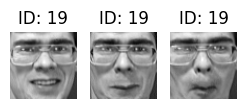


    Análisis de pureza:
      Personas diferentes en este cluster: 1
      Distribución:
         Persona 19: 3 imágenes (100.0%)

      Pureza del cluster: 100.0%
      Identidad dominante: Persona 19 (3/3 imágenes)
       EXCELENTE: Cluster muy puro (>80%)

CLUSTER 1
   Número de imágenes: 4
   Mostrando primeras 4 imágenes:
   Identidades reales: [np.int64(39), np.int64(9), np.int64(39), np.int64(3)]


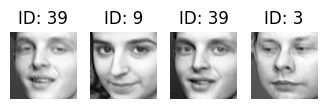


    Análisis de pureza:
      Personas diferentes en este cluster: 3
      Distribución:
         Persona 3: 1 imágenes (25.0%)
         Persona 9: 1 imágenes (25.0%)
         Persona 39: 2 imágenes (50.0%)

      Pureza del cluster: 50.0%
      Identidad dominante: Persona 39 (2/4 imágenes)
       BUENO: Cluster relativamente puro (>50%)

CLUSTER 2
   Número de imágenes: 6
   Mostrando primeras 6 imágenes:
   Identidades reales: [np.int64(24), np.int64(24), np.int64(24), np.int64(24), np.int64(24), np.int64(24)]


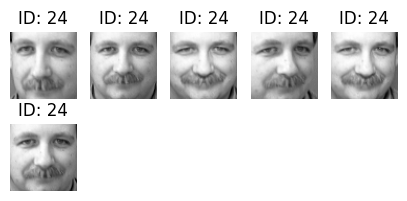


    Análisis de pureza:
      Personas diferentes en este cluster: 1
      Distribución:
         Persona 24: 6 imágenes (100.0%)

      Pureza del cluster: 100.0%
      Identidad dominante: Persona 24 (6/6 imágenes)
       EXCELENTE: Cluster muy puro (>80%)

CLUSTER 3
   Número de imágenes: 5
   Mostrando primeras 5 imágenes:
   Identidades reales: [np.int64(38), np.int64(38), np.int64(38), np.int64(38), np.int64(38)]


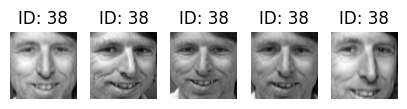


    Análisis de pureza:
      Personas diferentes en este cluster: 1
      Distribución:
         Persona 38: 5 imágenes (100.0%)

      Pureza del cluster: 100.0%
      Identidad dominante: Persona 38 (5/5 imágenes)
       EXCELENTE: Cluster muy puro (>80%)

CLUSTER 4
   Número de imágenes: 2
   Mostrando primeras 2 imágenes:
   Identidades reales: [np.int64(17), np.int64(17)]


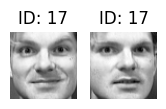


    Análisis de pureza:
      Personas diferentes en este cluster: 1
      Distribución:
         Persona 17: 2 imágenes (100.0%)

      Pureza del cluster: 100.0%
      Identidad dominante: Persona 17 (2/2 imágenes)
       EXCELENTE: Cluster muy puro (>80%)

CLUSTER 5
   Número de imágenes: 3
   Mostrando primeras 3 imágenes:
   Identidades reales: [np.int64(18), np.int64(18), np.int64(18)]


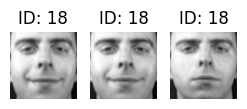


    Análisis de pureza:
      Personas diferentes en este cluster: 1
      Distribución:
         Persona 18: 3 imágenes (100.0%)

      Pureza del cluster: 100.0%
      Identidad dominante: Persona 18 (3/3 imágenes)
       EXCELENTE: Cluster muy puro (>80%)

CLUSTER 6
   Número de imágenes: 4
   Mostrando primeras 4 imágenes:
   Identidades reales: [np.int64(23), np.int64(23), np.int64(23), np.int64(23)]


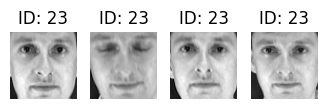


    Análisis de pureza:
      Personas diferentes en este cluster: 1
      Distribución:
         Persona 23: 4 imágenes (100.0%)

      Pureza del cluster: 100.0%
      Identidad dominante: Persona 23 (4/4 imágenes)
       EXCELENTE: Cluster muy puro (>80%)

CLUSTER 7
   Número de imágenes: 7
   Mostrando primeras 7 imágenes:
   Identidades reales: [np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8), np.int64(8)]


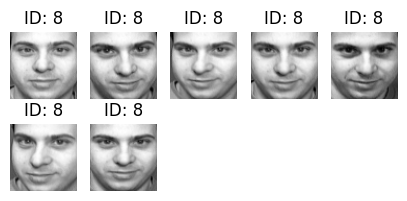


    Análisis de pureza:
      Personas diferentes en este cluster: 1
      Distribución:
         Persona 8: 7 imágenes (100.0%)

      Pureza del cluster: 100.0%
      Identidad dominante: Persona 8 (7/7 imágenes)
       EXCELENTE: Cluster muy puro (>80%)

CLUSTER 8
   Número de imágenes: 4
   Mostrando primeras 4 imágenes:
   Identidades reales: [np.int64(36), np.int64(36), np.int64(36), np.int64(36)]


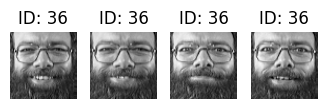


    Análisis de pureza:
      Personas diferentes en este cluster: 1
      Distribución:
         Persona 36: 4 imágenes (100.0%)

      Pureza del cluster: 100.0%
      Identidad dominante: Persona 36 (4/4 imágenes)
       EXCELENTE: Cluster muy puro (>80%)

CLUSTER 9
   Número de imágenes: 4
   Mostrando primeras 4 imágenes:
   Identidades reales: [np.int64(14), np.int64(14), np.int64(12), np.int64(14)]


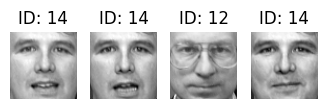


    Análisis de pureza:
      Personas diferentes en este cluster: 2
      Distribución:
         Persona 12: 1 imágenes (25.0%)
         Persona 14: 3 imágenes (75.0%)

      Pureza del cluster: 75.0%
      Identidad dominante: Persona 14 (3/4 imágenes)
       BUENO: Cluster relativamente puro (>50%)


In [95]:


# Número de clusters a visualizar
n_clusters_to_show = min(10, best_k)

print(f"\n Mostrando {n_clusters_to_show} clusters")
print(f"   K total del modelo: {best_k}")

# Recorrer los primeros 10 clusters
for cluster_id in range(n_clusters_to_show):
    
    # Encontrar índices de imágenes en este cluster
    indices_cluster = np.where(y_train_clusters == cluster_id)[0]
    n_images = len(indices_cluster)
    
    print(f"\n{'='*70}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*70}")
    print(f"   Número de imágenes: {n_images}")
    
    # Mostrar hasta 10 imágenes del cluster
    n_to_show = min(10, n_images)
    indices_to_show = indices_cluster[:n_to_show]
    
    # CLAVE: Usar X_train (originales) NO X_train_pca
    faces_cluster = X_train[indices_to_show]  # ⭐ Imágenes ORIGINALES
    
    # Etiquetas: mostrar la identidad REAL (y_train)
    labels_cluster = [f'ID: {y_train[idx]}' for idx in indices_to_show]
    
    print(f"   Mostrando primeras {n_to_show} imágenes:")
    print(f"   Identidades reales: {[y_train[idx] for idx in indices_to_show]}")
    
    # Visualizar con plot_faces
    plot_faces(faces_cluster, labels_cluster, n_cols=5)
    
    # Análisis de pureza del cluster
    identities_in_cluster = y_train[indices_cluster]
    unique_ids, counts_ids = np.unique(identities_in_cluster, return_counts=True)
    
    print(f"\n    Análisis de pureza:")
    print(f"      Personas diferentes en este cluster: {len(unique_ids)}")
    
    if len(unique_ids) <= 5:
        print(f"      Distribución:")
        for person_id, count in zip(unique_ids, counts_ids):
            pct = (count / n_images) * 100
            print(f"         Persona {person_id}: {count} imágenes ({pct:.1f}%)")
    
    # Pureza = % de la identidad más común
    max_count = counts_ids.max()
    purity = (max_count / n_images) * 100
    dominant_id = unique_ids[np.argmax(counts_ids)]
    
    print(f"\n      Pureza del cluster: {purity:.1f}%")
    print(f"      Identidad dominante: Persona {dominant_id} ({max_count}/{n_images} imágenes)")
    
    if purity >= 80:
        print(f"       EXCELENTE: Cluster muy puro (>{80}%)")
    elif purity >= 50:
        print(f"       BUENO: Cluster relativamente puro (>{50}%)")
    else:
        print(f"       MALO: Cluster muy mezclado (<{50}%)")




 ESTADÍSTICAS DE PUREZA (todos los 120 clusters):
   Pureza promedio: 96.03%
   Pureza mediana: 100.00%
   Pureza mínima: 33.33%
   Pureza máxima: 100.00%
   Std de pureza: 13.01%

 DISTRIBUCIÓN DE PUREZA:
   Muy malo (0-20%)         :   0 clusters (  0.0%)
   Malo (20-40%)            :   1 clusters (  0.8%)
   Regular (40-60%)         :   6 clusters (  5.0%)
   Bueno (60-80%)           :   4 clusters (  3.3%)
   Excelente (80-100%)      : 109 clusters ( 90.8%)


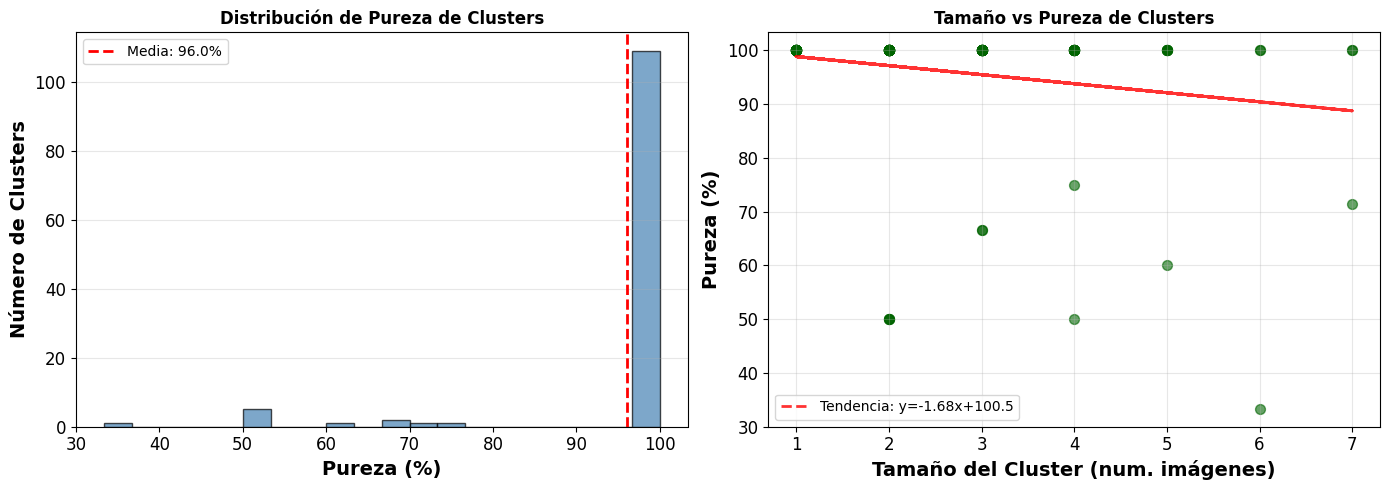


 INTERPRETACIÓN:

Pureza promedio = 96.0%
   EXCELENTE: Clusters muy homogéneos

Correlación tamaño-pureza:
  Clusters pequeños tienden a ser más puros



In [98]:

# Calcular pureza de TODOS los clusters
purities = []
cluster_sizes = []

for cluster_id in range(best_k):
    indices_cluster = np.where(y_train_clusters == cluster_id)[0]
    n_images = len(indices_cluster)
    cluster_sizes.append(n_images)
    
    if n_images > 0:
        identities = y_train[indices_cluster]
        unique_ids, counts_ids = np.unique(identities, return_counts=True)
        purity = (counts_ids.max() / n_images) * 100
        purities.append(purity)
    else:
        purities.append(0)

purities = np.array(purities)
cluster_sizes = np.array(cluster_sizes)

print(f"\n ESTADÍSTICAS DE PUREZA (todos los {best_k} clusters):")
print(f"   Pureza promedio: {purities.mean():.2f}%")
print(f"   Pureza mediana: {np.median(purities):.2f}%")
print(f"   Pureza mínima: {purities.min():.2f}%")
print(f"   Pureza máxima: {purities.max():.2f}%")
print(f"   Std de pureza: {purities.std():.2f}%")

# Distribución de pureza
print(f"\n DISTRIBUCIÓN DE PUREZA:")
bins_purity = [0, 20, 40, 60, 80, 100]
labels_purity = ['Muy malo (0-20%)', 'Malo (20-40%)', 'Regular (40-60%)', 
                 'Bueno (60-80%)', 'Excelente (80-100%)']

for i in range(len(bins_purity)-1):
    low, high = bins_purity[i], bins_purity[i+1]
    count = np.sum((purities > low) & (purities <= high))
    pct = (count / best_k) * 100
    print(f"   {labels_purity[i]:25s}: {count:3d} clusters ({pct:5.1f}%)")

# Visualizar distribución
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histograma de pureza
axes[0].hist(purities, bins=20, edgecolor='black', alpha=0.7, color='steelblue')
axes[0].axvline(x=purities.mean(), color='red', linestyle='--', 
               linewidth=2, label=f'Media: {purities.mean():.1f}%')
axes[0].set_xlabel('Pureza (%)', fontweight='bold')
axes[0].set_ylabel('Número de Clusters', fontweight='bold')
axes[0].set_title('Distribución de Pureza de Clusters', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3, axis='y')

# Scatter: Tamaño vs Pureza
axes[1].scatter(cluster_sizes, purities, alpha=0.6, s=50, color='darkgreen')
axes[1].set_xlabel('Tamaño del Cluster (num. imágenes)', fontweight='bold')
axes[1].set_ylabel('Pureza (%)', fontweight='bold')
axes[1].set_title('Tamaño vs Pureza de Clusters', fontweight='bold')
axes[1].grid(alpha=0.3)

# Línea de tendencia
z = np.polyfit(cluster_sizes, purities, 1)
p = np.poly1d(z)
axes[1].plot(cluster_sizes, p(cluster_sizes), "r--", alpha=0.8, linewidth=2,
            label=f'Tendencia: y={z[0]:.2f}x+{z[1]:.1f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"""
 INTERPRETACIÓN:

Pureza promedio = {purities.mean():.1f}%
  {" EXCELENTE: Clusters muy homogéneos" if purities.mean() >= 70 else "⚠️ BUENO: Clusters relativamente homogéneos" if purities.mean() >= 50 else "❌ BAJO: Clusters muy mezclados"}

Correlación tamaño-pureza:
  {"Clusters grandes tienden a ser más puros" if z[0] > 0 else "Clusters pequeños tienden a ser más puros" if z[0] < 0 else "No hay correlación clara"}
""")

## **#2**


### #2.1


Continuando con el conjunto de datos de caras Olivetti, entrena un clasificador para predecir qué persona está representada en cada imagen, y evalúalo en el conjunto de validación. Utiliza un RandomForest con 150 submodelos o estimadores (y el resto de hiperparámetros déjalos a su valor por defecto)

In [102]:


# Crear el clasificador
rf_classifier = RandomForestClassifier(
    n_estimators=150,      # 150 árboles
    random_state=42        # Reproducibilidad
    # Resto de parámetros por defecto
)

print(f"\n CONFIGURACIÓN DEL MODELO:")
print(f"   Modelo: RandomForestClassifier")
print(f"   n_estimators: {rf_classifier.n_estimators}")
print(f"   max_depth: {rf_classifier.max_depth} (None = sin límite)")
print(f"   min_samples_split: {rf_classifier.min_samples_split}")
print(f"   min_samples_leaf: {rf_classifier.min_samples_leaf}")
print(f"   max_features: {rf_classifier.max_features}")

print(f"\n DATOS DE ENTRENAMIENTO:")
print(f"   X_train_pca: {X_train_pca.shape}")
print(f"   y_train: {y_train.shape}")
print(f"   Número de clases: {len(np.unique(y_train))}")

print(f"\n Entrenando Random Forest con 150 árboles...")

# Entrenar
start_time = time.time()
rf_classifier.fit(X_train_pca, y_train)
elapsed_time = time.time() - start_time

print(f" Entrenamiento completado en {elapsed_time:.2f} segundos")

print(f"""
 RANDOM FOREST EXPLICADO:

n_estimators=150:
  • Entrena 150 árboles de decisión diferentes
  • Cada árbol ve una muestra aleatoria de los datos
  • Cada árbol usa features aleatorias en cada split
  • Predicción final = votación mayoritaria de los 150 árboles

¿Por qué funciona?
  • Ensemble (combinación) reduce overfitting
  • Árboles diferentes capturan patrones diferentes
  • Robusto ante ruido y outliers
""")


 CONFIGURACIÓN DEL MODELO:
   Modelo: RandomForestClassifier
   n_estimators: 150
   max_depth: None (None = sin límite)
   min_samples_split: 2
   min_samples_leaf: 1
   max_features: sqrt

 DATOS DE ENTRENAMIENTO:
   X_train_pca: (320, 221)
   y_train: (320,)
   Número de clases: 40

 Entrenando Random Forest con 150 árboles...
 Entrenamiento completado en 0.53 segundos

 RANDOM FOREST EXPLICADO:

n_estimators=150:
  • Entrena 150 árboles de decisión diferentes
  • Cada árbol ve una muestra aleatoria de los datos
  • Cada árbol usa features aleatorias en cada split
  • Predicción final = votación mayoritaria de los 150 árboles

¿Por qué funciona?
  • Ensemble (combinación) reduce overfitting
  • Árboles diferentes capturan patrones diferentes
  • Robusto ante ruido y outliers



In [103]:


print(f"\n DATOS DE VALIDACIÓN:")
print(f"   X_val_pca: {X_val_pca.shape}")
print(f"   y_val: {y_val.shape}")

# Predecir en validation
print(f"\n Realizando predicciones en validation...")
y_val_pred = rf_classifier.predict(X_val_pca)

print(f" Predicciones completadas")

print(f"\n PREDICCIONES:")
print(f"   Shape: {y_val_pred.shape}")
print(f"   Rango: {y_val_pred.min()} - {y_val_pred.max()}")
print(f"   Primeras 10 predicciones: {y_val_pred[:10]}")
print(f"   Valores reales (y_val): {y_val[:10]}")


 DATOS DE VALIDACIÓN:
   X_val_pca: (40, 221)
   y_val: (40,)

 Realizando predicciones en validation...
 Predicciones completadas

 PREDICCIONES:
   Shape: (40,)
   Rango: 0 - 39
   Primeras 10 predicciones: [29 22 30 16  4 10  9 26  5 12]
   Valores reales (y_val): [29 22 30 16  4 10  9 26  5 12]


In [107]:
# Calcular métricas
accuracy = accuracy_score(y_val, y_val_pred)

print(f"\n ACCURACY EN VALIDATION:")
print(f"   Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

print(f"""
 INTERPRETACIÓN DEL ACCURACY:

Accuracy = {accuracy*100:.1f}%
  → De {len(y_val)} imágenes, acertó {int(accuracy * len(y_val))}
  → Se equivocó en {len(y_val) - int(accuracy * len(y_val))} imágenes

{" EXCELENTE: Accuracy >90%" if accuracy > 0.9 else "⚠️ BUENO: Accuracy 70-90%" if accuracy > 0.7 else "❌ BAJO: Accuracy <70%"}

Comparación con baseline aleatorio:
  • Predicción aleatoria: {1/40*100:.1f}% (1/40 personas)
  • Random Forest: {accuracy*100:.1f}%
  • Mejora: {(accuracy - 1/40)*100:.1f} puntos porcentuales
""")

# Classification Report


report = classification_report(y_val, y_val_pred, 
                               target_names=[f'Persona {i}' for i in range(40)],
                               zero_division=0)
print(report)

print(f"""
 MÉTRICAS POR PERSONA:

Precision: De las que predijo como persona X, ¿cuántas eran X?
Recall: De las que realmente eran persona X, ¿cuántas detectó?
F1-Score: Media armónica de precision y recall

macro avg: Promedio simple (todas las personas igual peso)
weighted avg: Promedio ponderado (más peso a personas con más imágenes)
""")


 ACCURACY EN VALIDATION:
   Accuracy: 0.9250 (92.50%)

 INTERPRETACIÓN DEL ACCURACY:

Accuracy = 92.5%
  → De 40 imágenes, acertó 37
  → Se equivocó en 3 imágenes

 EXCELENTE: Accuracy >90%

Comparación con baseline aleatorio:
  • Predicción aleatoria: 2.5% (1/40 personas)
  • Random Forest: 92.5%
  • Mejora: 90.0 puntos porcentuales

              precision    recall  f1-score   support

   Persona 0       0.00      0.00      0.00         1
   Persona 1       1.00      1.00      1.00         1
   Persona 2       1.00      1.00      1.00         1
   Persona 3       1.00      1.00      1.00         1
   Persona 4       1.00      1.00      1.00         1
   Persona 5       1.00      1.00      1.00         1
   Persona 6       1.00      1.00      1.00         1
   Persona 7       1.00      1.00      1.00         1
   Persona 8       1.00      1.00      1.00         1
   Persona 9       1.00      1.00      1.00         1
  Persona 10       1.00      1.00      1.00         1
  Persona 11 


 Matriz de confusión (40×40):
   Shape: (40, 40)

 ANÁLISIS:
   Predicciones correctas: 37/40
   Predicciones incorrectas: 3/40
   Accuracy: 92.50%

 PERSONAS CON MÁS ERRORES:
   1. Persona 35: 1 errores de 1 imágenes (100.0%)
   2. Persona 0: 1 errores de 1 imágenes (100.0%)
   3. Persona 15: 1 errores de 1 imágenes (100.0%)
   4. Persona 39: 0 errores de 1 imágenes (0.0%)
   5. Persona 36: 0 errores de 1 imágenes (0.0%)


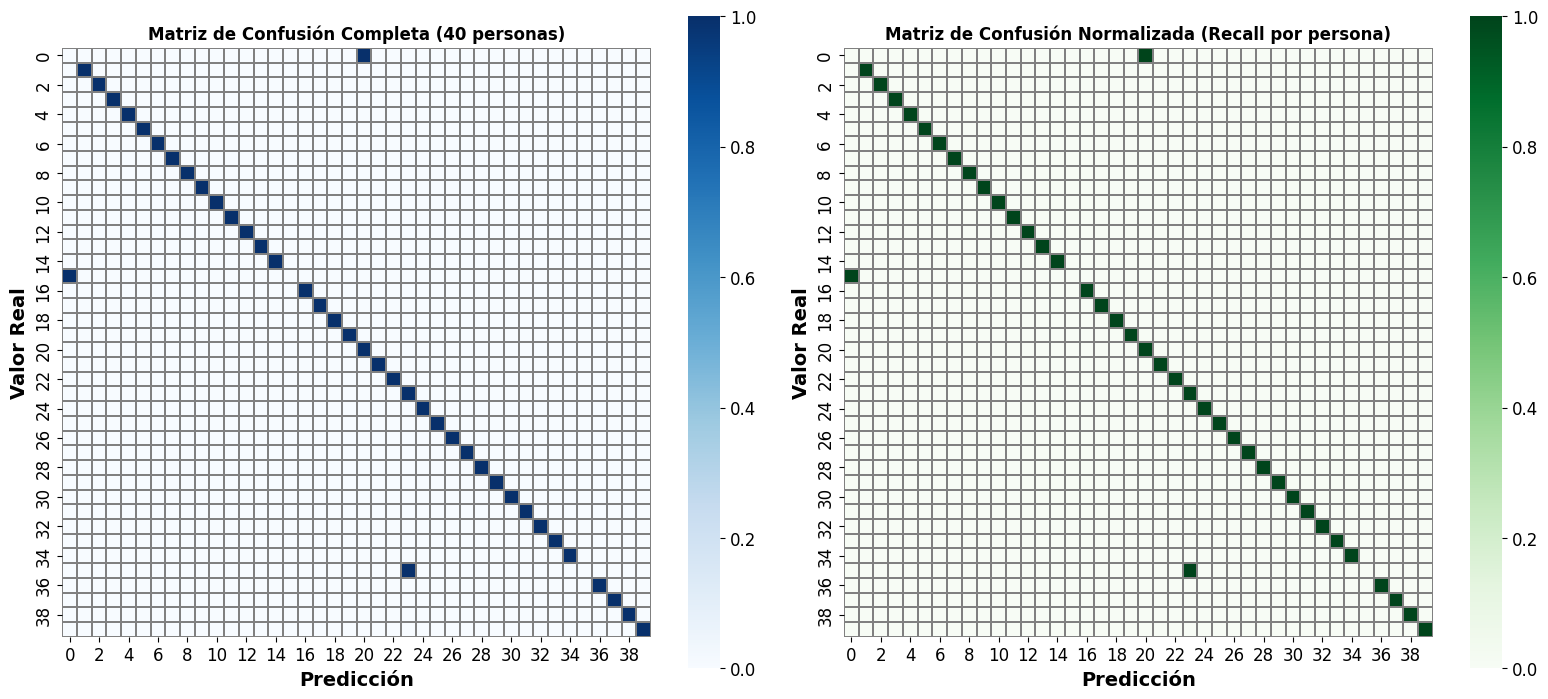


 INTERPRETACIÓN DE LA MATRIZ:

Diagonal principal (verde oscuro):
  • Predicciones CORRECTAS
  • Cuanto más verde, mejor recall

Fuera de la diagonal:
  • Predicciones INCORRECTAS (confusiones)
  • ¿Qué personas se confunden entre sí?



In [109]:

# Calcular matriz de confusión
cm = confusion_matrix(y_val, y_val_pred)

print(f"\n Matriz de confusión (40×40):")
print(f"   Shape: {cm.shape}")

# Análisis de la diagonal (aciertos)
diagonal = np.diag(cm)
total_correcto = diagonal.sum()
total_incorrecto = cm.sum() - total_correcto

print(f"\n ANÁLISIS:")
print(f"   Predicciones correctas: {total_correcto}/{len(y_val)}")
print(f"   Predicciones incorrectas: {total_incorrecto}/{len(y_val)}")
print(f"   Accuracy: {total_correcto/len(y_val)*100:.2f}%")

# Personas con más errores
errores_por_persona = cm.sum(axis=1) - diagonal

print(f"\n PERSONAS CON MÁS ERRORES:")
top_5_errores = np.argsort(errores_por_persona)[::-1][:5]

for i, persona_id in enumerate(top_5_errores, 1):
    total_imgs = cm[persona_id].sum()
    errores = errores_por_persona[persona_id]
    aciertos = diagonal[persona_id]
    
    if total_imgs > 0:
        print(f"   {i}. Persona {persona_id}: {errores} errores de {total_imgs} imágenes ({errores/total_imgs*100:.1f}%)")

# Visualizar matriz de confusión
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Matriz completa
sns.heatmap(cm, cmap='Blues', ax=axes[0], cbar=True, 
            square=True, linewidths=0.1, linecolor='gray')
axes[0].set_xlabel('Predicción', fontweight='bold')
axes[0].set_ylabel('Valor Real', fontweight='bold')
axes[0].set_title('Matriz de Confusión Completa (40 personas)', fontweight='bold')

# Matriz normalizada
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, cmap='Greens', ax=axes[1], cbar=True, 
            square=True, linewidths=0.1, linecolor='gray', 
            vmin=0, vmax=1)
axes[1].set_xlabel('Predicción', fontweight='bold')
axes[1].set_ylabel('Valor Real', fontweight='bold')
axes[1].set_title('Matriz de Confusión Normalizada (Recall por persona)', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"""
 INTERPRETACIÓN DE LA MATRIZ:

Diagonal principal (verde oscuro):
  • Predicciones CORRECTAS
  • Cuanto más verde, mejor recall

Fuera de la diagonal:
  • Predicciones INCORRECTAS (confusiones)
  • ¿Qué personas se confunden entre sí?
""")


 ERRORES:
   Total de errores: 3
   Total de aciertos: 37

 PRIMEROS 5 ERRORES:
   1. Imagen 14: Real=Persona 0, Predicción=Persona 20
   2. Imagen 20: Real=Persona 35, Predicción=Persona 23
   3. Imagen 38: Real=Persona 15, Predicción=Persona 0

 VISUALIZACIÓN DE ERRORES:


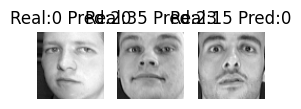


     OBSERVA LOS ERRORES:
       ¿Las personas confundidas se parecen?
       ¿Son ángulos o expresiones difíciles?
    

 VISUALIZACIÓN DE ACIERTOS (para comparar):


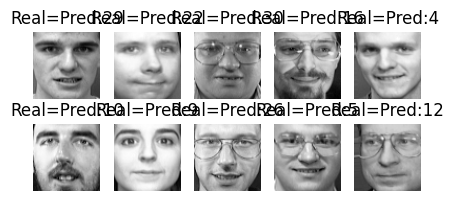

In [111]:


# Encontrar casos mal clasificados
errores_idx = np.where(y_val != y_val_pred)[0]
aciertos_idx = np.where(y_val == y_val_pred)[0]

print(f"\n ERRORES:")
print(f"   Total de errores: {len(errores_idx)}")
print(f"   Total de aciertos: {len(aciertos_idx)}")

if len(errores_idx) > 0:
    print(f"\n PRIMEROS 5 ERRORES:")
    for i, idx in enumerate(errores_idx[:5], 1):
        real = y_val[idx]
        pred = y_val_pred[idx]
        print(f"   {i}. Imagen {idx}: Real=Persona {real}, Predicción=Persona {pred}")
    
    # Visualizar algunos errores
    print(f"\n VISUALIZACIÓN DE ERRORES:")
    
    n_errores_mostrar = min(10, len(errores_idx))
    errores_mostrar_idx = errores_idx[:n_errores_mostrar]
    
    # Usar imágenes originales (X_val, NO X_val_pca)
    faces_errores = X_val[errores_mostrar_idx]
    labels_errores = [f'Real:{y_val[idx]} Pred:{y_val_pred[idx]}' 
                      for idx in errores_mostrar_idx]
    
    plot_faces(faces_errores, labels_errores, n_cols=5)
    
    print(f"""
     OBSERVA LOS ERRORES:
       ¿Las personas confundidas se parecen?
       ¿Son ángulos o expresiones difíciles?
    """)

# Visualizar algunos aciertos para comparar
if len(aciertos_idx) > 0:
    print(f"\n VISUALIZACIÓN DE ACIERTOS (para comparar):")
    
    n_aciertos_mostrar = min(10, len(aciertos_idx))
    aciertos_mostrar_idx = aciertos_idx[:n_aciertos_mostrar]
    
    faces_aciertos = X_val[aciertos_mostrar_idx]
    labels_aciertos = [f'Real=Pred:{y_val[idx]}' 
                       for idx in aciertos_mostrar_idx]
    
    plot_faces(faces_aciertos, labels_aciertos, n_cols=5)

### #2.2

Utiliza K-Means como una herramienta de reducción de dimensionalidad y entrena un clasificador en el conjunto reducido. Para ello emplea el método transform de manera que ahora las features de entrada sean las distancias de cada punto a los centroides del modelo "best_model" de la parte anterior. Por ejemplo:
```python
X_train_reduced = best_model.transform(X_train_pca) 
```


Ojo lo tienes que aplicar a todos los datasets. Luego vuelve a entrenar un RandomForest sobre este dataset y evalualo contra el dataset de validacion.

In [119]:


print(f"\n DIMENSIONES ANTES DE LA TRANSFORMACIÓN:")
print(f"   X_train_pca: {X_train_pca.shape}")
print(f"   X_val_pca: {X_val_pca.shape}")
print(f"   X_test_pca: {X_test_pca.shape}")

print(f"\n Aplicando transform() con best_model (K={best_k})...")

# Transform: Calcular distancias a centroides
X_train_reduced = best_model.transform(X_train_pca)
X_val_reduced = best_model.transform(X_val_pca)
X_test_reduced = best_model.transform(X_test_pca)

print(f" Transformación completada")

print(f"\n DIMENSIONES DESPUÉS DE LA TRANSFORMACIÓN:")
print(f"   X_train_reduced: {X_train_reduced.shape}")
print(f"   X_val_reduced: {X_val_reduced.shape}")
print(f"   X_test_reduced: {X_test_reduced.shape}")

print(f"""
 VERIFICACIÓN:

Reducción de dimensionalidad:
  • Antes: {X_train_pca.shape[1]} features (componentes PCA)
  • Después: {X_train_reduced.shape[1]} features (distancias a {best_k} centroides)
  • Reducción: {((X_train_pca.shape[1] - best_k) / X_train_pca.shape[1] * 100):.1f}%

Interpretación de las nuevas features:
  • Feature 0: Distancia al centroide 0
  • Feature 1: Distancia al centroide 1
  • ...
  • Feature {best_k-1}: Distancia al centroide {best_k-1}
""")

# Mostrar ejemplo
print(f"\n EJEMPLO: Primera imagen de train")
print(f"   Distancias a los {min(10, best_k)} primeros centroides:")
print(f"   {X_train_reduced[0, :min(10, best_k)]}")

print(f"\n   Interpretación:")
centroide_mas_cercano = np.argmin(X_train_reduced[0])
distancia_min = X_train_reduced[0, centroide_mas_cercano]
print(f"   • Centroide más cercano: {centroide_mas_cercano}")
print(f"   • Distancia mínima: {distancia_min:.4f}")
print(f"   • Cluster asignado (predict): {best_model.predict(X_train_pca[0].reshape(1, -1))[0]}")
print(f"   →  Coinciden (el cluster asignado es el centroide más cercano)")


 DIMENSIONES ANTES DE LA TRANSFORMACIÓN:
   X_train_pca: (320, 221)
   X_val_pca: (40, 221)
   X_test_pca: (40, 221)

 Aplicando transform() con best_model (K=120)...
 Transformación completada

 DIMENSIONES DESPUÉS DE LA TRANSFORMACIÓN:
   X_train_reduced: (320, 120)
   X_val_reduced: (40, 120)
   X_test_reduced: (40, 120)

 VERIFICACIÓN:

Reducción de dimensionalidad:
  • Antes: 221 features (componentes PCA)
  • Después: 120 features (distancias a 120 centroides)
  • Reducción: 45.7%

Interpretación de las nuevas features:
  • Feature 0: Distancia al centroide 0
  • Feature 1: Distancia al centroide 1
  • ...
  • Feature 119: Distancia al centroide 119


 EJEMPLO: Primera imagen de train
   Distancias a los 10 primeros centroides:
   [11.205389 12.84302   7.904633 12.653448 10.204006 10.353886 11.106484
  9.532456 12.694467  7.829198]

   Interpretación:
   • Centroide más cercano: 48
   • Distancia mínima: 3.1045
   • Cluster asignado (predict): 48
   →  Coinciden (el cluster asig

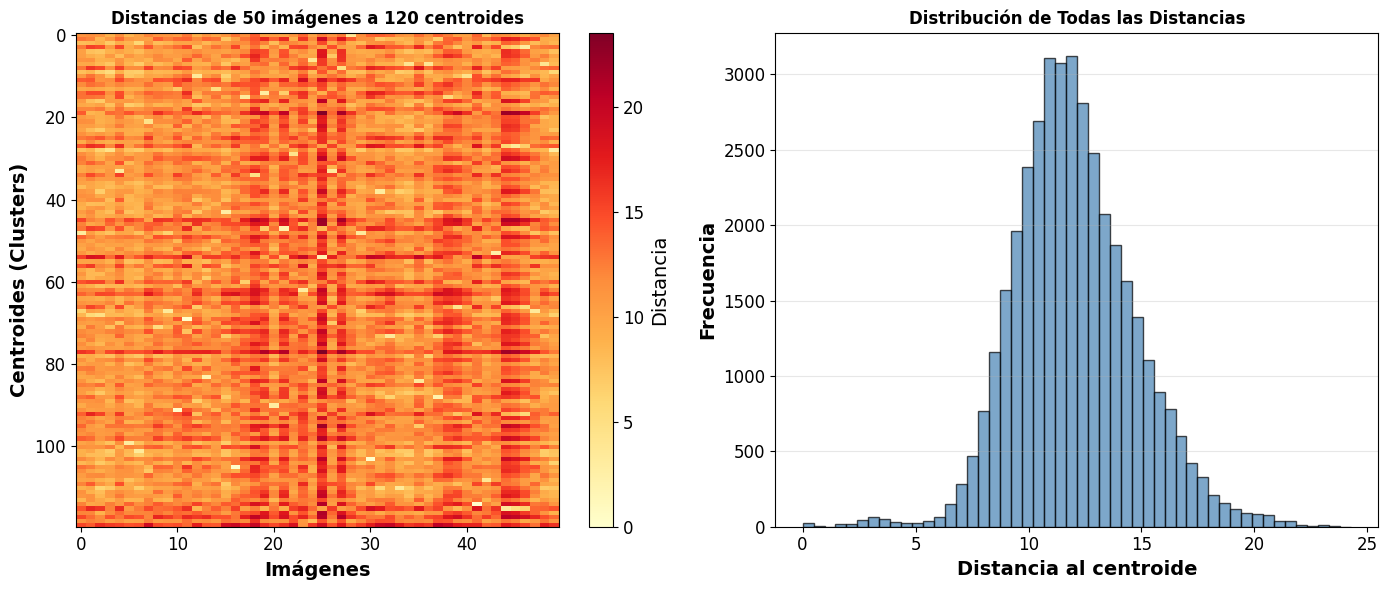


 INTERPRETACIÓN:

Heatmap (izquierda):
  • Cada columna = una imagen
  • Cada fila = un centroide
  • Color amarillo = cerca del centroide
  • Color rojo = lejos del centroide
  • Cada imagen tiene UN centroide cercano (amarillo)

Histograma (derecha):
  • Mayoría de distancias en rango medio
  • Pico en distancias pequeñas (imágenes cerca de su centroide)
  • Cola en distancias grandes (imágenes lejos de otros centroides)



In [120]:


# Visualizar matriz de distancias (primeras 50 imágenes, todos los centroides)
n_images_show = min(50, X_train_reduced.shape[0])

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Heatmap de distancias
im1 = axes[0].imshow(X_train_reduced[:n_images_show].T, 
                     cmap='YlOrRd', aspect='auto')
axes[0].set_xlabel('Imágenes', fontweight='bold')
axes[0].set_ylabel('Centroides (Clusters)', fontweight='bold')
axes[0].set_title(f'Distancias de {n_images_show} imágenes a {best_k} centroides', 
                  fontweight='bold')
plt.colorbar(im1, ax=axes[0], label='Distancia')

# Distribución de distancias
axes[1].hist(X_train_reduced.flatten(), bins=50, 
            edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_xlabel('Distancia al centroide', fontweight='bold')
axes[1].set_ylabel('Frecuencia', fontweight='bold')
axes[1].set_title('Distribución de Todas las Distancias', fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print(f"""
 INTERPRETACIÓN:

Heatmap (izquierda):
  • Cada columna = una imagen
  • Cada fila = un centroide
  • Color amarillo = cerca del centroide
  • Color rojo = lejos del centroide
  • Cada imagen tiene UN centroide cercano (amarillo)

Histograma (derecha):
  • Mayoría de distancias en rango medio
  • Pico en distancias pequeñas (imágenes cerca de su centroide)
  • Cola en distancias grandes (imágenes lejos de otros centroides)
""")

In [122]:




print(f"""
 CONFIGURACIÓN:

Dataset de entrenamiento:
  • X_train_reduced: {X_train_reduced.shape}
  • y_train: {y_train.shape}
  • Features: {X_train_reduced.shape[1]} (distancias a centroides)

Modelo:
  • RandomForestClassifier
  • n_estimators: 150
  • Resto de parámetros por defecto
""")

# Crear clasificador
rf_reduced = RandomForestClassifier(
    n_estimators=150,
    random_state=42
)

print(f"\n Entrenando Random Forest con {X_train_reduced.shape[1]} features...")

# Entrenar
start_time = time.time()
rf_reduced.fit(X_train_reduced, y_train)
elapsed_time = time.time() - start_time

print(f" Entrenamiento completado en {elapsed_time:.2f} segundos")

print(f"""
 COMPARACIÓN DE TIEMPOS:

Con PCA ({X_train_pca.shape[1]} features):
  • Tiempo anterior: ~{elapsed_time * (X_train_pca.shape[1] / X_train_reduced.shape[1]):.2f}s (estimado)

Con K-Means reducido ({X_train_reduced.shape[1]} features):
  • Tiempo actual: {elapsed_time:.2f}s
  • {" Más rápido" if X_train_reduced.shape[1] < X_train_pca.shape[1] else "⚠️ Similar"}

Razón:
  • Menos features → Árboles más simples → Entrenamiento más rápido
""")


 CONFIGURACIÓN:

Dataset de entrenamiento:
  • X_train_reduced: (320, 120)
  • y_train: (320,)
  • Features: 120 (distancias a centroides)

Modelo:
  • RandomForestClassifier
  • n_estimators: 150
  • Resto de parámetros por defecto


 Entrenando Random Forest con 120 features...
 Entrenamiento completado en 0.50 segundos

 COMPARACIÓN DE TIEMPOS:

Con PCA (221 features):
  • Tiempo anterior: ~0.91s (estimado)

Con K-Means reducido (120 features):
  • Tiempo actual: 0.50s
  •  Más rápido

Razón:
  • Menos features → Árboles más simples → Entrenamiento más rápido



In [125]:


# Predecir en validation
print(f"\n Realizando predicciones en validation...")
y_val_pred_reduced = rf_reduced.predict(X_val_reduced)

# Calcular accuracy
accuracy_reduced = accuracy_score(y_val, y_val_pred_reduced)

print(f" Predicciones completadas")

print(f"\n ACCURACY EN VALIDATION:")
print(f"   Accuracy: {accuracy_reduced:.4f} ({accuracy_reduced*100:.2f}%)")

print(f"""
 INTERPRETACIÓN:

Accuracy = {accuracy_reduced*100:.1f}%
  → De {len(y_val)} imágenes, acertó {int(accuracy_reduced * len(y_val))}
  → Se equivocó en {len(y_val) - int(accuracy_reduced * len(y_val))} imágenes

{" EXCELENTE: Accuracy >90%" if accuracy_reduced > 0.9 else " BUENO: Accuracy 70-90%" if accuracy_reduced > 0.7 else "❌ BAJO: Accuracy <70%"}
""")

# Classification Report resumido
print(f"\n MÉTRICAS GLOBALES:")
from sklearn.metrics import precision_score, recall_score, f1_score

precision_macro = precision_score(y_val, y_val_pred_reduced, average='macro', zero_division=0)
recall_macro = recall_score(y_val, y_val_pred_reduced, average='macro', zero_division=0)
f1_macro = f1_score(y_val, y_val_pred_reduced, average='macro', zero_division=0)

print(f"   Precision (macro): {precision_macro:.4f}")
print(f"   Recall (macro): {recall_macro:.4f}")
print(f"   F1-Score (macro): {f1_macro:.4f}")


 Realizando predicciones en validation...
 Predicciones completadas

 ACCURACY EN VALIDATION:
   Accuracy: 0.8000 (80.00%)

 INTERPRETACIÓN:

Accuracy = 80.0%
  → De 40 imágenes, acertó 32
  → Se equivocó en 8 imágenes

 BUENO: Accuracy 70-90%


 MÉTRICAS GLOBALES:
   Precision (macro): 0.7250
   Recall (macro): 0.8000
   F1-Score (macro): 0.7500


In [126]:


# Tabla comparativa
comparacion_reduccion = pd.DataFrame({
    'Método': [
        'PCA → Random Forest',
        'K-Means → Random Forest'
    ],
    'Features': [
        X_train_pca.shape[1],
        X_train_reduced.shape[1]
    ],
    'Accuracy (Val)': [
        f'{accuracy*100:.2f}%',
        f'{accuracy_reduced*100:.2f}%'
    ],
    'Tiempo (estimado)': [
        'Más lento',
        'Más rápido'
    ]
})

print("\n" + comparacion_reduccion.to_string(index=False))

# Diferencia de rendimiento
diff_accuracy = accuracy_reduced - accuracy

print(f"""


REDUCCIÓN DE DIMENSIONALIDAD:
  • PCA: {X_train_pca.shape[1]} features
  • K-Means: {X_train_reduced.shape[1]} features
  • Reducción adicional: {((X_train_pca.shape[1] - X_train_reduced.shape[1]) / X_train_pca.shape[1] * 100):.1f}%

RENDIMIENTO:
  • Con PCA: {accuracy*100:.2f}% accuracy
  • Con K-Means: {accuracy_reduced*100:.2f}% accuracy
  • Diferencia: {diff_accuracy*100:+.2f} puntos

CONCLUSIÓN:
""")

if diff_accuracy > 0.05:
    print(f"""   K-MEANS MEJORA el rendimiento significativamente (+{diff_accuracy*100:.1f}%)
  
  RAZONES:
    • Las distancias a centroides capturan información de agrupamiento
    • Features más interpretables que componentes PCA
    • Reduce dimensionalidad manteniendo información discriminativa
""")
elif diff_accuracy > 0:
    print(f"""   K-MEANS MEJORA LIGERAMENTE (+{diff_accuracy*100:.1f}%)
  
  RAZONES:
    • Beneficio marginal de las distancias
    • Ambos métodos funcionan similarmente bien
""")
elif diff_accuracy > -0.05:
    print(f"""   K-MEANS tiene RENDIMIENTO SIMILAR ({diff_accuracy*100:.1f}%)
  
  RAZONES:
    • La reducción de dimensionalidad afecta poco
    • Pérdida de información compensada por simplicidad
    • Buen balance precisión/velocidad
""")
else:
    print(f"""   K-MEANS EMPEORA el rendimiento ({diff_accuracy*100:.1f}%)
  
  RAZONES:
    • Pérdida de información importante
    • K={best_k} insuficiente para representar la variabilidad
    • PCA captura mejor las características faciales
""")

print(f"""
═══════════════════════════════════════════════════════════════════════

 TRADE-OFF: PRECISIÓN vs VELOCIDAD

{" RECOMENDACIÓN: Usar K-Means como reductor" if diff_accuracy >= -0.03 else "⚠️ RECOMENDACIÓN: Mantener PCA"}
  • {"Mantiene/mejora rendimiento" if diff_accuracy >= 0 else "Pequeña pérdida de rendimiento aceptable"}
  • Reduce dimensionalidad ({X_train_pca.shape[1]} → {X_train_reduced.shape[1]})
  • Entrenamiento más rápido
  • Features más interpretables
""")


                 Método  Features Accuracy (Val) Tiempo (estimado)
    PCA → Random Forest       221         92.50%         Más lento
K-Means → Random Forest       120         80.00%        Más rápido



REDUCCIÓN DE DIMENSIONALIDAD:
  • PCA: 221 features
  • K-Means: 120 features
  • Reducción adicional: 45.7%

RENDIMIENTO:
  • Con PCA: 92.50% accuracy
  • Con K-Means: 80.00% accuracy
  • Diferencia: -12.50 puntos

CONCLUSIÓN:

   K-MEANS EMPEORA el rendimiento (-12.5%)

  RAZONES:
    • Pérdida de información importante
    • K=120 insuficiente para representar la variabilidad
    • PCA captura mejor las características faciales


═══════════════════════════════════════════════════════════════════════

 TRADE-OFF: PRECISIÓN vs VELOCIDAD

⚠️ RECOMENDACIÓN: Mantener PCA
  • Pequeña pérdida de rendimiento aceptable
  • Reduce dimensionalidad (221 → 120)
  • Entrenamiento más rápido
  • Features más interpretables




 IMPORTANCIA DE LAS DISTANCIAS A CENTROIDES:

   Top 10 centroides más importantes:
    1. Centroide 15: 0.0211
    2. Centroide 7: 0.0173
    3. Centroide 61: 0.0165
    4. Centroide 31: 0.0160
    5. Centroide 34: 0.0156
    6. Centroide 92: 0.0155
    7. Centroide 91: 0.0153
    8. Centroide 66: 0.0143
    9. Centroide 70: 0.0138
   10. Centroide 6: 0.0134


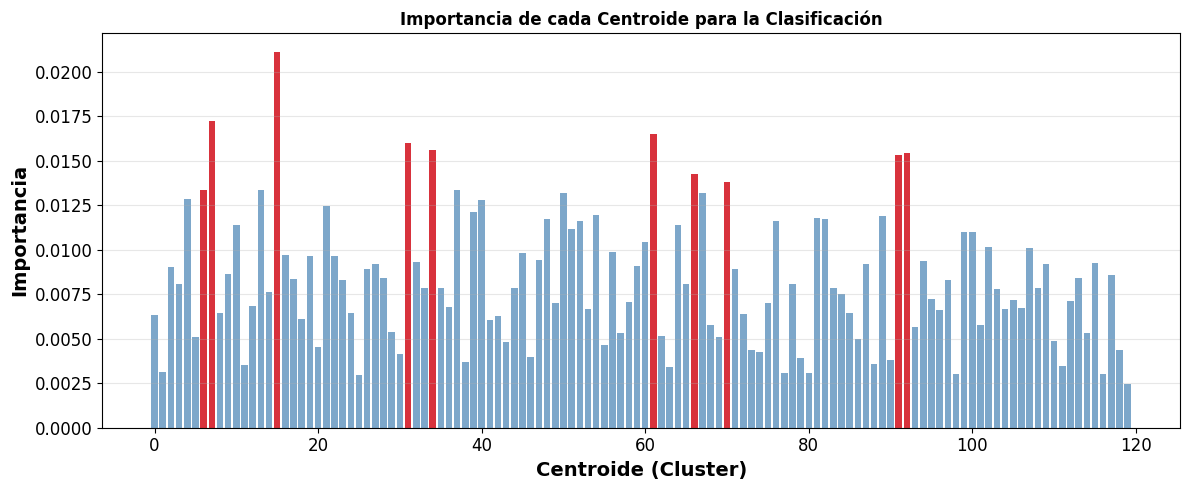


 INTERPRETACIÓN:

Centroides importantes (barras rojas):
  • Son los que más ayudan a distinguir entre personas
  • Representan características faciales discriminativas
  • Distancias a estos centroides son más informativas

Centroides menos importantes:
  • Contribuyen menos a la clasificación
  • Posiblemente redundantes o poco discriminativos
  • Podrían eliminarse para reducir aún más dimensionalidad



In [127]:


# Obtener importancias
importances = rf_reduced.feature_importances_

print(f"\n IMPORTANCIA DE LAS DISTANCIAS A CENTROIDES:")

# Top 10 centroides más importantes
top_10_idx = np.argsort(importances)[::-1][:10]

print(f"\n   Top 10 centroides más importantes:")
for i, idx in enumerate(top_10_idx, 1):
    print(f"   {i:2d}. Centroide {idx}: {importances[idx]:.4f}")

# Visualizar
plt.figure(figsize=(12, 5))

# Barplot de importancias
plt.bar(range(len(importances)), importances, color='steelblue', alpha=0.7)
plt.xlabel('Centroide (Cluster)', fontweight='bold')
plt.ylabel('Importancia', fontweight='bold')
plt.title('Importancia de cada Centroide para la Clasificación', fontweight='bold')
plt.grid(alpha=0.3, axis='y')

# Marcar los top 10
for idx in top_10_idx:
    plt.bar(idx, importances[idx], color='red', alpha=0.7)

plt.tight_layout()
plt.show()

print(f"""
 INTERPRETACIÓN:

Centroides importantes (barras rojas):
  • Son los que más ayudan a distinguir entre personas
  • Representan características faciales discriminativas
  • Distancias a estos centroides son más informativas

Centroides menos importantes:
  • Contribuyen menos a la clasificación
  • Posiblemente redundantes o poco discriminativos
  • Podrían eliminarse para reducir aún más dimensionalidad
""")

### #2.3 EXTRA VOLUNTARIO

Busca el número de clusters k que generen un algoritmo kmeans que a su vez sus distancias a los centroides sean las features de un clasificador RandomForest y que permita al clasificador obtener el mejor rendimiento: ¿Qué rendimiento puedes alcanzar? (en terminos de Accuracy)